<a href="https://colab.research.google.com/github/Ananassio/Data-Science_lab/blob/main/Project/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importieren der Daten

In [1]:
#get data from server
!wget --no-check-certificate https://www.keuper-labs.org/project_ss22.zip

--2022-06-19 19:48:51--  https://www.keuper-labs.org/project_ss22.zip
Resolving www.keuper-labs.org (www.keuper-labs.org)... 91.250.118.129
Connecting to www.keuper-labs.org (www.keuper-labs.org)|91.250.118.129|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 70859177 (68M) [application/zip]
Saving to: ‘project_ss22.zip.2’

project_ss22.zip.2  100%[===================>]  67.58M  11.4MB/s    in 6.4s    

2022-06-19 19:48:58 (10.6 MB/s) - ‘project_ss22.zip.2’ saved [70859177/70859177]



In [2]:
#unpack
!unzip project_ss22.zip

Archive:  project_ss22.zip
replace dressipi_recsys2022/candidate_items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install dask-ml[xgboost]    # also install xgboost and dask-xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# import some libarys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [6]:
# asign the Data to variables
items = pd.read_csv('dressipi_recsys2022/candidate_items.csv')
features = pd.read_csv('dressipi_recsys2022/item_features.csv')
train_purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv')
train_sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv')
test_leaderboard_sessions = pd.read_csv('dressipi_recsys2022/test_leaderboard_sessions.csv')

## Blick auf die Daten
Hier werden zunächst die Datensätze einmal ausgegeben, um einen Überblick 
zubekommen wie diese aufgebaut sind.



---




In dem items Datensatz sind die item ids, welche in bei den testsessions gekauft wurden 

In [7]:
items

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [8]:
#how many items do we have?
items.describe()

,item_id
count,4990.000000
mean,14007.035271
std,8218.231425
min,4.000000
25%,6833.500000
50%,14108.500000
75%,21200.000000
max,28137.000000




---


In dem features Dataset sind die entsprechenden item features der jeweiligen items aufgelistet. Dabei werden die feature Kategorien wie Farbe, Ausschnitt, etc mit einer value id z.B. grün beschrieben. Die einzelnen items haben mehrere Kategorien, welche die items beschreiben, siehe hier z.B. item 2 hat 13 feature Kategorien.

In [9]:
features

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [10]:
features.describe()

,item_id,feature_category_id,feature_value_id
count,471751.000000,471751.000000,471751.000000
mean,14058.539477,42.424597,486.345578
std,8107.465455,22.186285,258.865151
min,2.000000,1.000000,1.000000
25%,7060.000000,25.000000,273.000000
50%,14045.000000,47.000000,512.000000
75%,21063.000000,61.000000,708.000000
max,28143.000000,73.000000,905.000000




---


Der Train_purchases Datensatz beinhaltet eine item id, welche am Ende der jeweiligen session letzlich gekauft wurde. Zusätzlich gibt es dabei noch einen Zeitstempel.
Die gesamten Daten wurden in einem Zeitraum von 18 Monaten aufgezeichnet, dabei wurden Daten der ersten 17 Monate für den Trainingsdatensatz verwendet und der letzte Monat wurde für den Testdatensatz verwendet.

In [11]:
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356




---


In dem Datensatz train_session sind die item ids aufgelistet, welche innerhalb einer session angesehen wurden. Auch hier gibt es jeweils einen Zeitstempel.

In [12]:
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186




---


Auf den Daten des Datensatzes test_leaderboard_session sollen die Vorhersagen für die Bestenliste des Wettbewerbs getätigt werden. 

In [13]:
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Datenanalyse
Hier soll ein überblick geschaffen werden, wie die Daten verteilt sind

## Anzahl der Sessions pro Kauf

In [ ]:
# first count the ammount of the session numbers
A = pd.DataFrame(train_sessions['session_id'].value_counts().sort_values())['session_id'].value_counts()

In [ ]:
A.to_frame()

,session_id
1,307698
2,174775
3,115499
4,82306
5,60695
...,...
100,6
91,6
98,5
99,5


In [ ]:
# lets use the describe function for better analysing of the numbers 
train_sessions['session_id'].value_counts().sort_values().describe()

count    1000000.000000
mean           4.743820
std            6.084665
min            1.000000
25%            1.000000
50%            3.000000
75%            6.000000
max          100.000000
Name: session_id, dtype: float64

In diesem Plot ist die Anzahl der Sessions für einen kauf dargestellt. Dabei liegt der Mittlewert für die Sessionanzahl bei 4.743820.

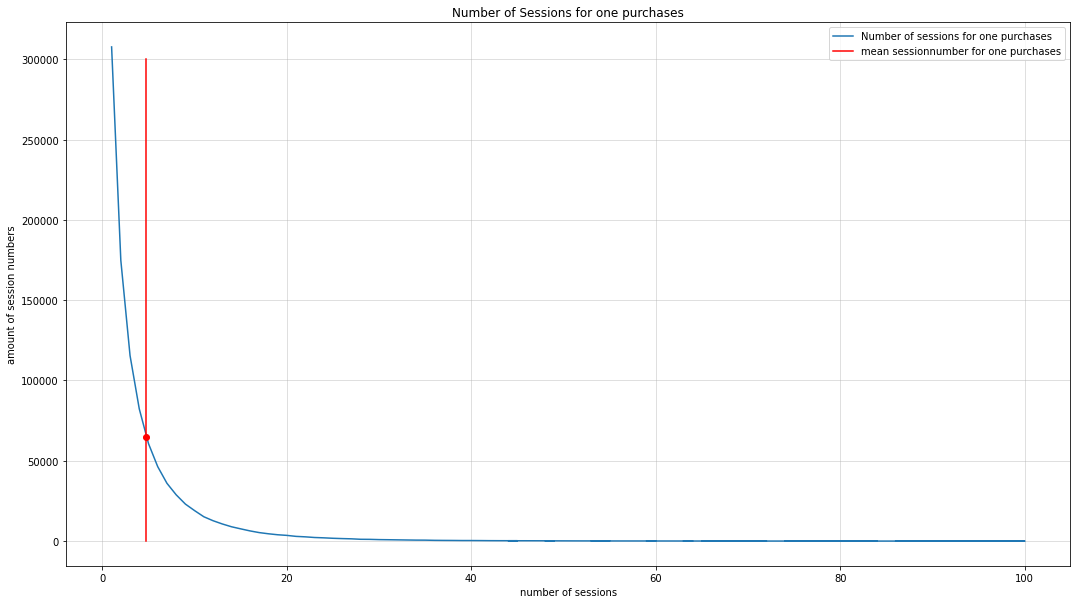

In [ ]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.plot(A,label='Number of sessions for one purchases')
#plot the mean session
axes.plot([4.743820,4.743820], [0,300000], '-r', label='mean sessionnumber for one purchases')
axes.plot(4.743820,65000, 'ro')
#set the labeling
axes.set_xlabel('number of sessions')
axes.set_ylabel('amount of session numbers')
axes.set_title('Number of Sessions for one purchases');
axes.grid(alpha=0.5)
axes.legend()

## Verteilung der Käufe
Als nächsten Schritt wird geschaut an welchen Tagen, zu welchen Uhrzeiten und in welchem Monat die Items gekauft werden.


In [ ]:
# look at the train_purchases Dataset
# label the purchases 
t_purchase_times = pd.DataFrame();
#day
t_purchase_times['day']=pd.to_datetime(train_sessions['date']).dt.day_name()
#month
t_purchase_times['month']=pd.to_datetime(train_sessions['date']).dt.month_name()
#year
t_purchase_times['year']=pd.to_datetime(train_sessions['date']).dt.year
#daytime
t_purchase_times['part_of_day'] = (pd.to_datetime(train_sessions['date']).dt.hour % 24 + 4) // 4
t_purchase_times['part_of_day'].replace({1: 'Late Night', # 0-4 Uhr
                      2: 'Early Morning',                 # 4-8 Uhr
                      3: 'Morning',                       # 8-12 Uhr
                      4: 'Noon',                          # 12-16 Uhr
                      5: 'Evening',                       # 16-20 Uhr
                      6: 'Night'}, inplace=True)          # 20-0 Uhr
t_purchase_times

,day,month,year,part_of_day
0,Friday,December,2020,Night
1,Friday,December,2020,Night
2,Friday,March,2020,Evening
3,Wednesday,August,2020,Evening
4,Wednesday,August,2020,Evening
...,...,...,...,...
4743815,Friday,October,2020,Night
4743816,Friday,October,2020,Night
4743817,Friday,October,2020,Night
4743818,Friday,October,2020,Night


In [ ]:
#how many items where bought in each year
t_purchase_times['year'].value_counts()

2020    3197810
2021    1546010
Name: year, dtype: int64

Werden die Käufe auf die Wochentage verteilt, lässt sich erkennen, dass die meisten Käufe am Wochenende getätigt werden und die wenigsten in der Mitte der Woche.

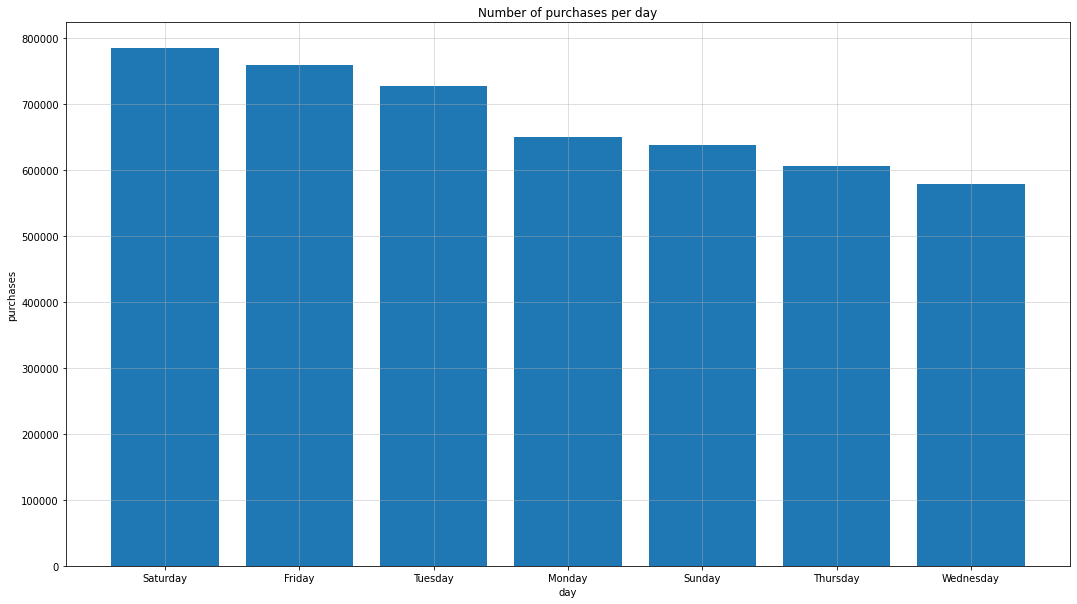

In [ ]:
# print the number of purchases per day
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['day'].value_counts().index,t_purchase_times['day'].value_counts())
#set the labeling
axes.set_xlabel('day')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per day');
axes.grid(alpha=0.5)

Über ein Jahr verteilt sind die meisten Käufe gegen Ende des Jahres, ein Grund hierfür könnten die Weihnachtseinkäufe sein. 

Auffällig ist außerdem, dass im Jahr 2021 jeden Monat die Käufe des jahres 2020 übertroffen wurden. Ein Grund hierfür könnten die Lockdown Maßnahmen sein, welche wegen der Corona-Pandemie ab November 2020 beschlossen wurden.

Da die Trainingsdaten nur über einen Zeitraum von 17 Monaten aufgezeichhnet wurden gibt es für das Jahr 2021 nur für die ersten fünf Monate Daten. 



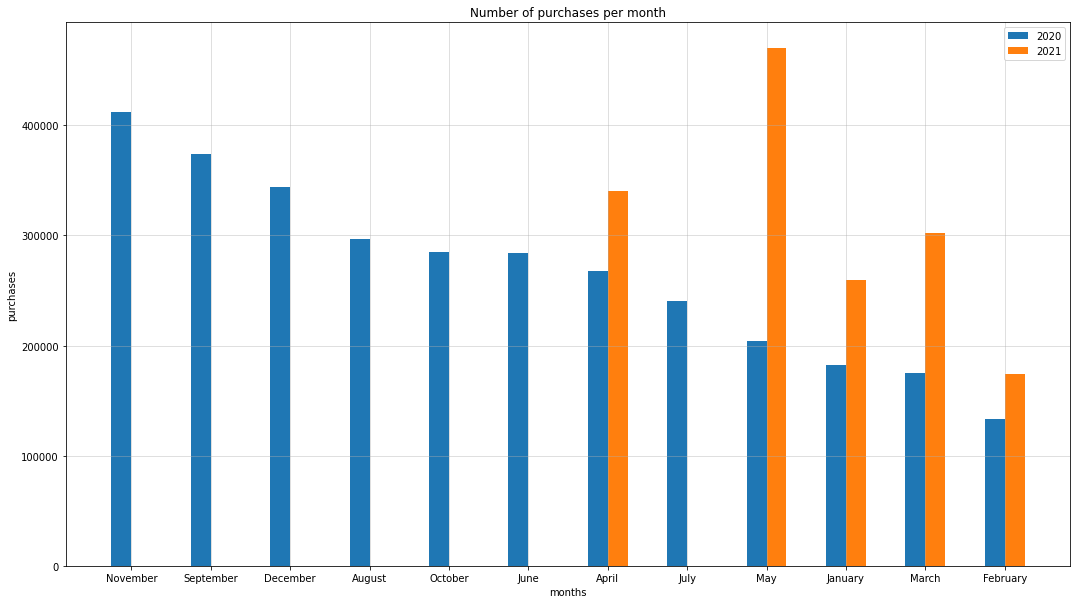

In [ ]:
# print the number of purchases per month
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts(),align='edge', width=-0.25,label='2020')
axes.bar(t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts(),align='edge', width=0.25,label='2021')
#set the labeling
axes.set_xlabel('months')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per month');
axes.grid(alpha=0.5)
axes.legend(loc=1);

Ein Blick auf die Verteilung der Käufe über einen Tag zeigen, dass mit abstand die wenigsten Käufe zwischen "late night" (0-4 Uhr) und "early morning" (4-8 Uhr) getätigt werden. Die restlichen Käufe wiederum teilen sich auf den verbleibenden Tage auf, wobei dabei die meisten im "evening" (16-20 Uhr) getätigt werden.

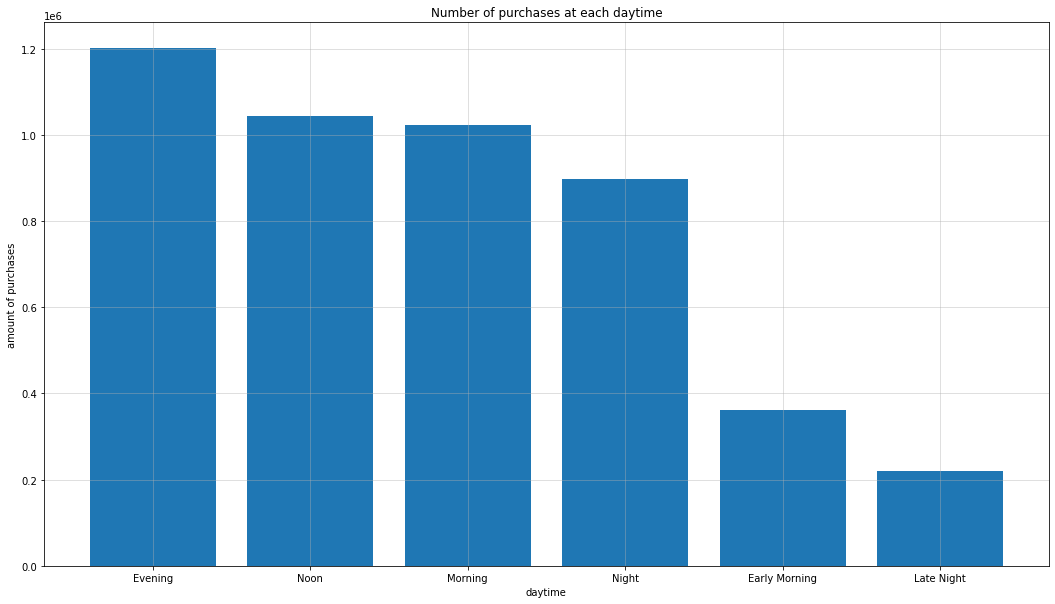

In [ ]:
# print the number of purchases per daytime
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['part_of_day'].value_counts().index,t_purchase_times['part_of_day'].value_counts())
#set the labeling
axes.set_xlabel('daytime')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases at each daytime');
axes.grid(alpha=0.5)

## Welche Items wurden oft gekauft

Hier wird angesehen wie oft welches Item gekauft wurde. Also ob es bestimmte Items gibt die besonders oft gekauft werden.

Im Durchschnit wird ein item ~53 mal gekauft und das am häufigsten verkaufte item wurde 8451 mal verkauft.

In [ ]:
train_purchases['item_id'].value_counts()

8060     8451
26853    3829
19882    3355
8622     2745
2447     2726
         ... 
20141       1
24646       1
1581        1
14660       1
3302        1
Name: item_id, Length: 18907, dtype: int64

In [ ]:
train_purchases['item_id'].value_counts().describe()

count    18907.000000
mean        52.890464
std        126.716155
min          1.000000
25%          7.000000
50%         26.000000
75%         61.000000
max       8451.000000
Name: item_id, dtype: float64

werden die anzahl der Käufe pro item ausgegeben, sind einige Ausreißer, welche deutlich öfter gekauft wurden als z.B. der Durchschnitt.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


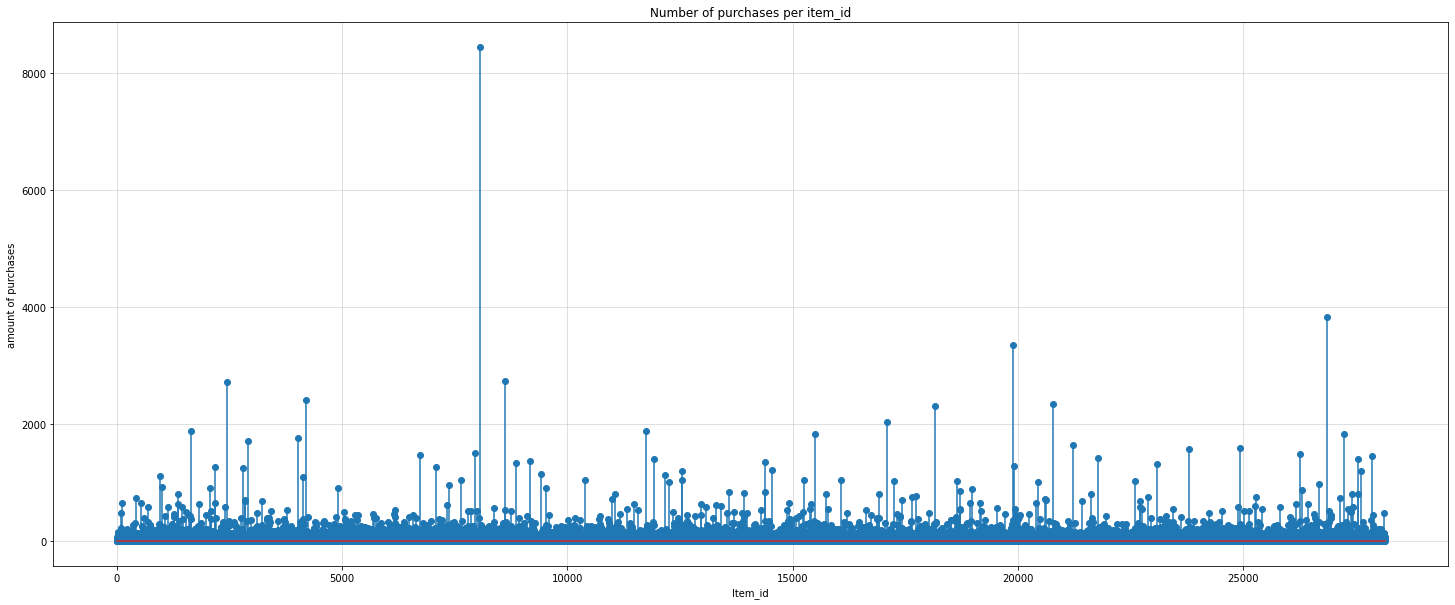

In [ ]:
# print the Number of purchases per item_id
fig, axes = plt.subplots(figsize=(25,10))

axes.stem(train_purchases['item_id'].value_counts().index, train_purchases['item_id'].value_counts())
#set the labeling
axes.set_xlabel('Item_id')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item_id');
axes.grid(alpha=0.5)

Ebenfalls deutlich wird dies bei der Ausgabe eines Boxplottes.

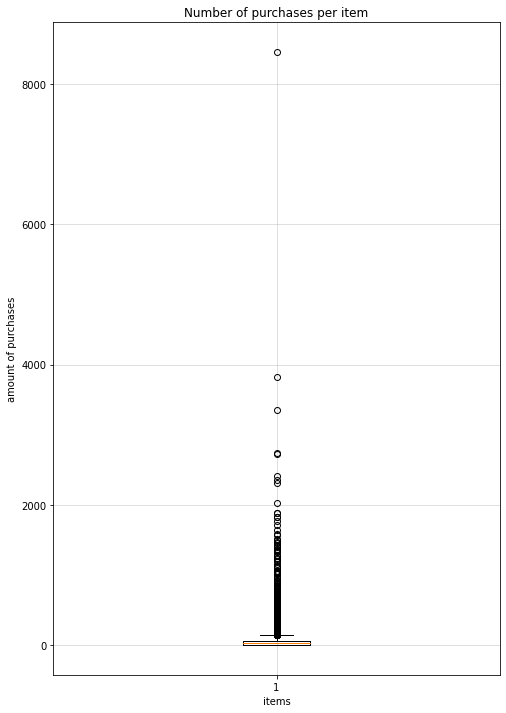

In [ ]:
fig, axes = plt.subplots(figsize=(8,12))
#plot the boxplot of the number of purchases
axes.boxplot(train_purchases['item_id'].value_counts())
#set the labeling
axes.set_xlabel('items')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item');
axes.grid(alpha=0.5)

Ein Histogramm der letzen 18500 von den 18907 items zeigt, dass die meisten items unter 100 mal gekauft wurden. (zur besseren Darstellung wurden hier die letzten 407 Items entfernt, da diese besonders oft gekauft wurden und so das Histogramm nicht mehr "gut" darstellbar ist).

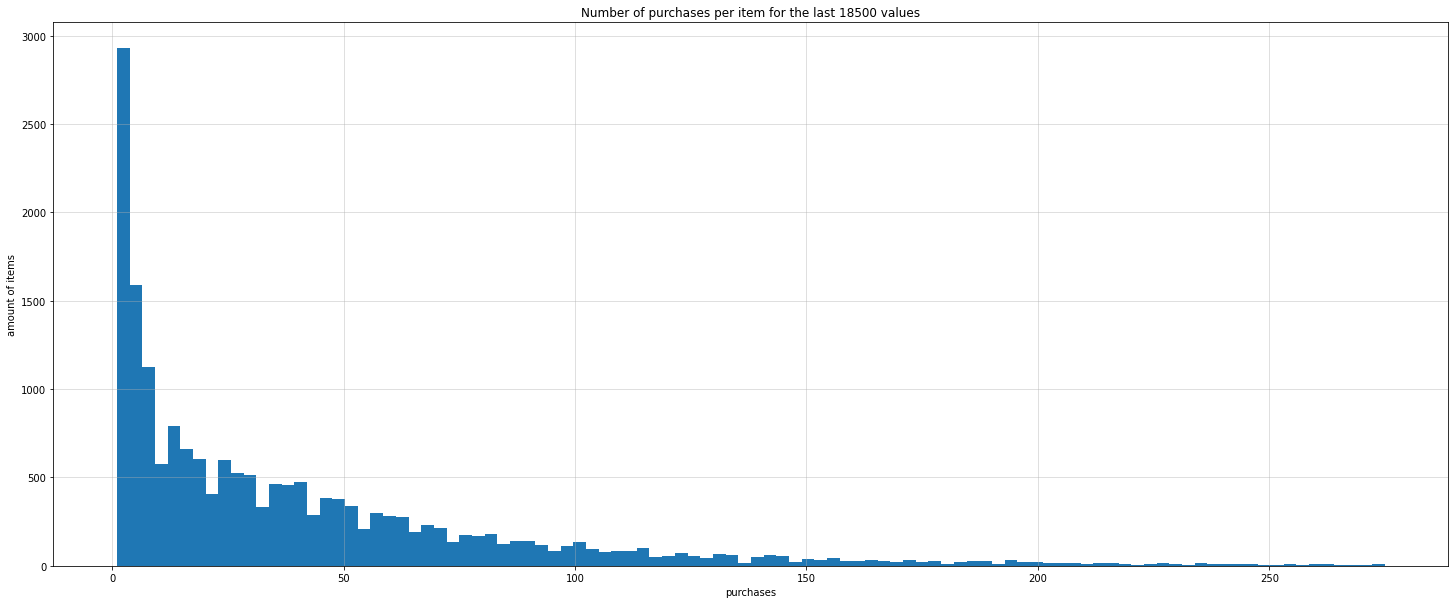

In [ ]:
fig, axes = plt.subplots(figsize=(25,10))
#plot the histogram of the number of purchases for the last 18500 Items
axes.hist(train_purchases['item_id'].value_counts().tail(18500), bins=100)
#set the labeling
axes.set_xlabel('purchases')
axes.set_ylabel('amount of items')
axes.set_title('Number of purchases per item for the last 18500 values');
axes.grid(alpha=0.5)

### Meistgekauften Items
in diesem Abschnitt wird anschaut wie die meist verkauften Items im Bezug auf die gesamten Verkäufe verteilt sind.

Interesant ist hier, dass von den 18907 items

*   die  500 meistverkaufte items (2,64 % der verkauften items) über 25 % der Gesamtverkäufe
*   die  900 meistverkaufte items (4,76 % der verkauften items) über 33 % der Gesamtverkäufe
*   die 2500 meistverkaufte items (13,22 % der verkauften items) über 50 % der Gesamtverkäufe
*   die 5500 meistverkaufte items (29,02 % der verkauften items) über 75 % der Gesamtverkäufe
*   die 9454 meistverkaufte items (50,00 % der verkauften items) über 90 % der Gesamtverkäufe

ausmachen.



In [ ]:
#purchased items
print('all in all there were',train_purchases['item_id'].value_counts().sum(), 'items sold.')

all in all there were 1000000 items sold.


the 500 most sold items ( 2.64 % of the sold items) make 262909 sales. So they make over one quater of the total sales.( 26.29 %)



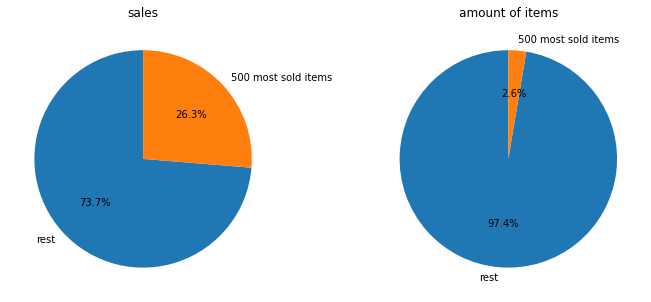

In [ ]:
#purchases of the 500 most sold items
print('the 500 most sold items (',round(500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(500).sum(), 
      'sales. So they make over one quater of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(500).sum(),
         train_purchases['item_id'].value_counts().head(500).sum()]
sizes2 = [ (18907-500)/18907,500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 900 most sold items ( 4.76 % of the sold items) make 344324 sales. So they make over one third of the total sales.( 34.43 %)



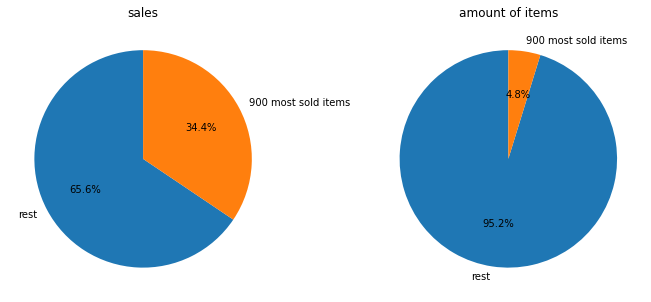

In [ ]:
#purchases of the 900 most sold items
print('the 900 most sold items (',round(900/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(900).sum(), 
      'sales. So they make over one third of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(900).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '900 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(900).sum(),
         train_purchases['item_id'].value_counts().head(900).sum()]
sizes2 = [ (18907-900)/18907,900/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 2500 most sold items ( 13.22 % of the sold items) make 545255 sales. So they make over the half of the total sales.( 54.53 %)



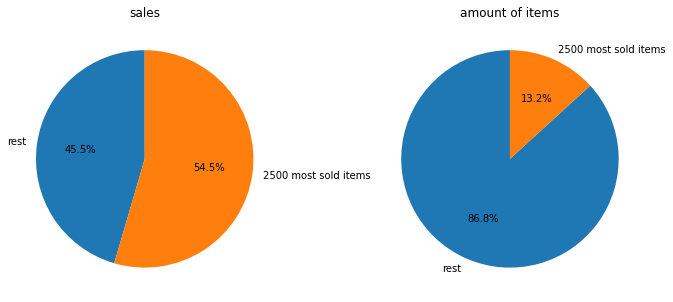

In [ ]:
#purchases of the 2500 most sold items
print('the 2500 most sold items (',round(2500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(2500).sum(), 
      'sales. So they make over the half of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(2500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '2500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(2500).sum(),
         train_purchases['item_id'].value_counts().head(2500).sum()]
sizes2 = [ (18907-2500)/18907,2500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 5500 most sold items ( 29.09 % of the sold items) make 758659 sales. So they make over three quaters of the total sales.( 75.87 %)



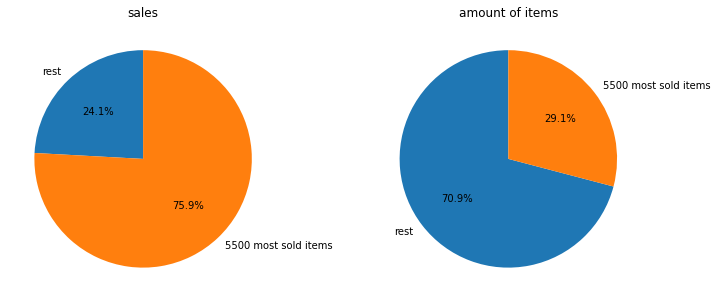

In [ ]:
#purchases of the 5500 most sold items
print('the 5500 most sold items (',round(5500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(5500).sum(), 
      'sales. So they make over three quaters of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(5500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '5500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(5500).sum(),
         train_purchases['item_id'].value_counts().head(5500).sum()]
sizes2 = [ (18907-5500)/18907,5500/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 9454 most sold items ( 50.0 % of the sold items) make 912344 sales. So they make over 90 % of the total sales.( 91.23 %)



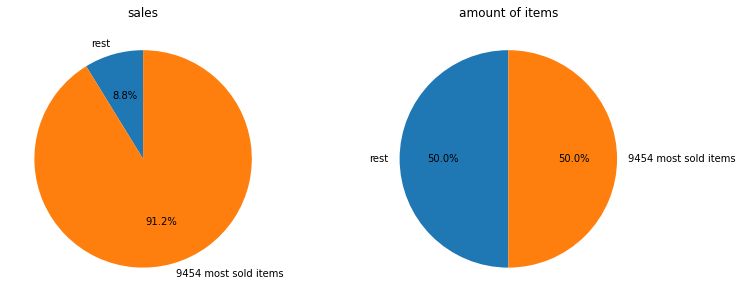

In [ ]:
#purchases of the 9454 most sold items
print('the 9454 most sold items (',round(9454/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(9454).sum(), 
      'sales. So they make over 90 % of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(9454).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '9454 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(9454).sum(),
         train_purchases['item_id'].value_counts().head(9454).sum()]
sizes2 = [ (18907-9454)/18907,9454/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

# Data Wrangling

Um die features nutzbar zu machen, soll der Datensatz in einer Tabelle mit der item_id als index und die feature_category_ids als spalten dargestellt werde.
Allerdings gibt es in dem features Dataframe doppelte Einträge, wodurch die pivot funktion nicht direkt angewendet werden kann. 
(Damit der code an einem Stück durchlaufen kann, wurde hierfür ein Screenshot der Fehlermelung eingefügt)
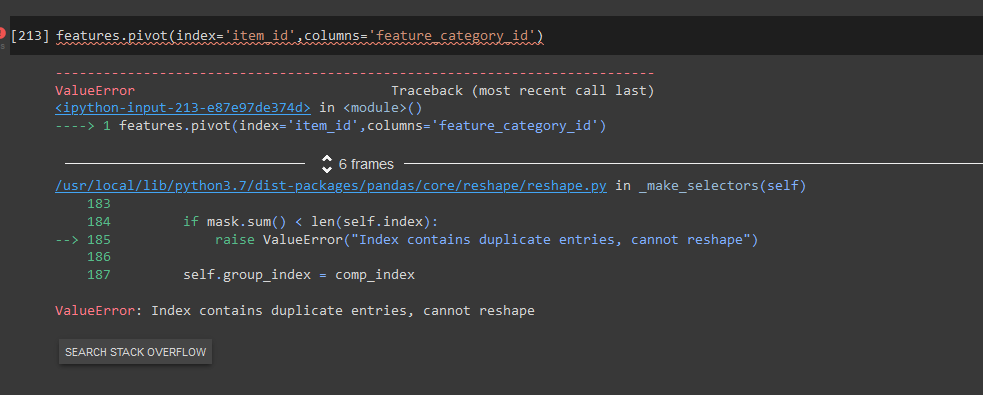

## Finden der doppelten feature_category_ids

In [ ]:
#search for the duplicated feature_ids in the features DataFrame
# first drop the feature_value_id so that the duplicated feature_ids can be found
a = features.drop(['feature_value_id'],axis=1)
doub_cats = [0]*6;
j = 0;
for i in a['feature_category_id'].unique():
  if a[a['feature_category_id']== i].duplicated().sum() > 0:
    doub_cats[j] = i;
    j= j+1;
print('the duplicadet feature_category_ids are:');
doub_cats

the duplicadet feature_category_ids are:


[53, 46, 4, 30, 28, 1]

In [ ]:
 #check if the duplicates are correct
 features[features['feature_category_id'] == 30]

,item_id,feature_category_id,feature_value_id
129,10,30,564
134,10,30,482
153,11,30,847
154,11,30,478
156,11,30,715
...,...,...,...
471557,28133,30,482
471561,28133,30,194
471590,28135,30,564
471593,28135,30,478


In [ ]:
#print in witch feature_value_ids are on the feature_category_id 30 
vals_id30 = features[features['feature_category_id'] == 30]['feature_value_id'].unique()
vals_id30.sort()
vals_id30

array([ 37,  42,  48,  62, 107, 118, 127, 136, 141, 150, 154, 173, 194,
       203, 228, 235, 259, 271, 285, 291, 325, 360, 375, 377, 391, 392,
       413, 417, 419, 426, 435, 453, 466, 478, 482, 493, 497, 532, 562,
       564, 582, 613, 638, 640, 641, 648, 654, 661, 669, 670, 715, 721,
       775, 790, 807, 809, 820, 827, 832, 835, 847, 867, 869, 880, 891,
       892, 900])

Ausgeben wie häufig die feature_category_ids mehrfach belegt sind.   

In [ ]:
for i in doub_cats:
  print('There are max',features[features['feature_category_id'] == i]['item_id'].value_counts().max(), 'times the feature_category_id', i, ' in one item')

There are max 2 times the feature_category_id 53  in one item
There are max 2 times the feature_category_id 46  in one item
There are max 4 times the feature_category_id 4  in one item
There are max 8 times the feature_category_id 30  in one item
There are max 3 times the feature_category_id 28  in one item
There are max 2 times the feature_category_id 1  in one item


Ausgeben wie viele verschiedene feature_value_ids die feature_category_ids haben

In [ ]:
for i in doub_cats:
  print('There are ',features[features['feature_category_id'] == i]['feature_value_id'].nunique(), 'different values in the feature_category_id', i, )



There are  5 different values in the feature_category_id 53
There are  4 different values in the feature_category_id 46
There are  16 different values in the feature_category_id 4
There are  67 different values in the feature_category_id 30
There are  6 different values in the feature_category_id 28
There are  6 different values in the feature_category_id 1


Um die feature_value_ids der feature_category_id 30 binär eindeutig zu codieren würden 8 * 1 Byte benötig. nachfolgen ein Beispiel wie dies aussehen könnte.

In [ ]:
bin(1<<(7*8)| 10<<(6*8) | 15<< (5*8) | 28 << (4*8) | 32 << (3*8) | 45 << (2*8) | 50 << (1*8) | 67<<(0*8))

'0b100001010000011110001110000100000001011010011001001000011'

In [ ]:
nums = features[features['feature_category_id'] == 30]['item_id'].value_counts()
nums.max()

8

In [ ]:
#ammount of items with the feature_category_id 30
nums.index

Int64Index([24947,  7970, 26951,  4585, 16345, 16355,  5124, 17903, 22880,
             3713,
            ...
             5527, 20501,  3108, 23737, 23735,  7496,  3111, 23727, 15054,
             3286],
           dtype='int64', length=5683)

## Umgangs Möglichkeiten mit den doppelten Einträgen

### Doppelte Einträge löschen

Eine Möglickeit besteht darin die feature_category_ids mit dopelten Einträgen zu löschen

In [ ]:
#first drop the duplicated to check if now no mare duplicates are here
c = features.drop(features[features['feature_category_id'] == 30].index)
c = c.drop(c[c['feature_category_id'] == 53].index)
c = c.drop(c[c['feature_category_id'] == 46].index)
c = c.drop(c[c['feature_category_id'] == 4].index)
c = c.drop(c[c['feature_category_id'] == 28].index)
c = c.drop(c[c['feature_category_id'] == 1].index)

Mit dem entfernen der feature_value_ids mit doppeltem vorkommen lässt sich nun die pivot function anwenden. Allerdings könnten so wichtige Eigenschaften, wie z.B. die Farben der Items nicht berücksichtigt sein.

In [ ]:
#now the pivot function works, but 6 feature_category_ids are dropped
c.pivot(index='item_id',columns='feature_category_id')

feature_value_id                                       \
feature_category_id               2      3      5   6      7   8   9   10   
item_id                                                                     
2                                NaN    NaN    NaN NaN  394.0 NaN NaN NaN   
3                                NaN  889.0  605.0 NaN  452.0 NaN NaN NaN   
4                                NaN  793.0  605.0 NaN  837.0 NaN NaN NaN   
7                                NaN    NaN    NaN NaN  536.0 NaN NaN NaN   
8                                NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
...                              ...    ...    ...  ..    ...  ..  ..  ..   
28139                            NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
28140                           53.0    NaN    NaN NaN    NaN NaN NaN NaN   
28141                            NaN  889.0  605.0 NaN    2.0 NaN NaN NaN   
28142                            NaN    NaN    NaN NaN  619.0 NaN NaN NaN   
28143                            NaN    NaN    NaN NaN  798.0 NaN NaN NaN   

                                ...                                            \
feature_category_id     11  12  ...    64     65  66     67     68     69  70   
item_id                         ...                                             
2                      NaN NaN  ...   NaN    NaN NaN    NaN  351.0  885.0 NaN   
3                    859.0 NaN  ...   NaN  521.0 NaN    NaN   14.0  592.0 NaN   
4                      NaN NaN  ...   NaN  521.0 NaN    NaN  373.0  538.0 NaN   
7                      NaN NaN  ...   NaN    NaN NaN    NaN  739.0  592.0 NaN   
8                    735.0 NaN  ...   NaN  521.0 NaN    NaN  351.0  592.0 NaN   
...                    ...  ..  ...   ...    ...  ..    ...    ...    ...  ..   
28139                  NaN NaN  ...   NaN  521.0 NaN    NaN  106.0  805.0 NaN   
28140                  NaN NaN  ...  80.0    NaN NaN  349.0  351.0    NaN NaN   
28141                  NaN NaN  ...   NaN    NaN NaN    NaN  379.0  499.0 NaN   
28142                  NaN NaN  ...   NaN  610.0 NaN    NaN  895.0  740.0 NaN   
28143                109.0 NaN  ...   NaN    NaN NaN    NaN  351.0  499.0 NaN   

                                          
feature_category_id     71     72     73  
item_id                                   
2                      NaN   75.0    NaN  
3                      NaN   75.0  544.0  
4                      NaN   75.0  544.0  
7                      NaN   75.0    NaN  
8                      NaN   75.0  544.0  
...                    ...    ...    ...  
28139                  NaN   75.0  544.0  
28140                226.0    NaN  544.0  
28141                  NaN   75.0  544.0  
28142                  NaN   75.0   91.0  
28143                  NaN  371.0   91.0  

[23691 rows x 67 columns]

### pivot_table Funktion verwenden

Eine andere Möglichkeit wäre die Funktion pivot_table, hier werden allerdings die doppelten Werte z.B. auf summiert oder deren Mittelwert gebildet, was auch zu einer verfälschung der Werte führt. Damit wären keine logischen zusammenhänge mehr möglich.
Wird jeweils der minimale oder maximale Wert verwendet gehen Daten verloren, aber es würde zumindest ein unrsprünglicher Wert erhaltenbleiben.

In [14]:
feature_pivtable = features.pivot_table(index='item_id',columns='feature_category_id',  fill_value=0,aggfunc='min')
feature_pivtable

feature_value_id                                      ...  \
feature_category_id               1   2    3    4    5  6    7  8  9  10  ...   
item_id                                                                   ...   
2                                  0   0    0    0    0  0  394  0  0  0  ...   
3                                  0   0  889  618  605  0  452  0  0  0  ...   
4                                  0   0  793  618  605  0  837  0  0  0  ...   
7                                  0   0    0    0    0  0  536  0  0  0  ...   
8                                  0   0  793  618  605  0  798  0  0  0  ...   
...                              ...  ..  ...  ...  ... ..  ... .. .. ..  ...   
28139                              0   0  793  618  605  0  798  0  0  0  ...   
28140                              0  53    0    0    0  0    0  0  0  0  ...   
28141                            461   0  889  719  605  0    2  0  0  0  ...   
28142                              0   0    0    0    0  0  619  0  0  0  ...   
28143                              0   0    0    0    0  0  798  0  0  0  ...   

                                                                  
feature_category_id  64   65 66   67   68   69 70   71   72   73  
item_id                                                           
2                     0    0  0    0  351  885  0    0   75    0  
3                     0  521  0    0   14  592  0    0   75  544  
4                     0  521  0    0  373  538  0    0   75  544  
7                     0    0  0    0  739  592  0    0   75    0  
8                     0  521  0    0  351  592  0    0   75  544  
...                  ..  ... ..  ...  ...  ... ..  ...  ...  ...  
28139                 0  521  0    0  106  805  0    0   75  544  
28140                80    0  0  349  351    0  0  226    0  544  
28141                 0    0  0    0  379  499  0    0   75  544  
28142                 0  610  0    0  895  740  0    0   75   91  
28143                 0    0  0    0  351  499  0    0  371   91  

[23691 rows x 73 columns]

Wie hier zusehen ist diese Matrix sparse, da auf die 73 feature_value_ids im durchschnittt nur rund 20 Werte kommen.

In [15]:
feature_pivtable.transpose().nunique().mean()

20.41817567852771

### Doppelte Einträge zusammenfassen

Eine dritte Möglichkeit besteht darin die doppelten Einträge zu codieren z.B. binär.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
e = enc.fit_transform(features)

In [ ]:
pd.DataFrame(e)

,0
0,"(0, 0)\t1.0\n (0, 23746)\t1.0\n (0, 24123)..."
1,"(0, 0)\t1.0\n (0, 23752)\t1.0\n (0, 24552)..."
2,"(0, 0)\t1.0\n (0, 23758)\t1.0\n (0, 24109)..."
3,"(0, 0)\t1.0\n (0, 23723)\t1.0\n (0, 24553)..."
4,"(0, 0)\t1.0\n (0, 23762)\t1.0\n (0, 23837)..."
...,...
471746,"(0, 23690)\t1.0\n (0, 23758)\t1.0\n (0, 24..."
471747,"(0, 23690)\t1.0\n (0, 23745)\t1.0\n (0, 24..."
471748,"(0, 23690)\t1.0\n (0, 23701)\t1.0\n (0, 23..."
471749,"(0, 23690)\t1.0\n (0, 23763)\t1.0\n (0, 23..."


In [ ]:
enc.fit_transform(features)

<471751x24654 sparse matrix of type '<class 'numpy.float64'>'
	with 1415253 stored elements in Compressed Sparse Row format>

In [ ]:
pd.get_dummies(features[features['feature_category_id'] == 46]['feature_value_id'])

,71,783,825,882
22,0,0,1,0
49,0,0,1,0
94,0,0,1,0
117,0,0,1,0
202,0,0,1,0
...,...,...,...,...
471501,0,0,1,0
471525,0,1,0,0
471649,0,0,1,0
471661,0,1,0,0


In [ ]:
a = pd.get_dummies(features[features['feature_category_id'] == 30]['feature_value_id'])
a

,37,42,48,62,107,118,127,136,141,150,...,827,832,835,847,867,869,880,891,892,900
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.packbits(list(a[a.index==129].values[0]),axis=0)

array([0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Das hatte allerdings nicht so richtig auf anhieb funktioniert. Deshalb und wegen der begrenzten Zeit wird darauf verzichtet und die Variante mit der pivot_table funktion weiter verfolgt.

# Baseline 

## Erstellen eines zufälligen Test scores
Erstellen eines Zufälligen Testscores mit je 100 zufälligen Item ids pro Session. Die item ids werden hierfür aus der items liste entnommen.
Der Score betrug dabei:  0.0010567088232443147 -> ~0,106 %

In [ ]:
#generate a random recomendation of the items out of items
rand_pred = pd.DataFrame();
#use the session ids out of the test_leaderboard_sessions
rand_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
#repeat each session 100 times
rand_pred  = rand_pred.loc[rand_pred.index.repeat(100)].reset_index(drop=True)
#pick randomo item ids
rand_pred['item_id'] = np.random.choice(items['item_id'], size=(len(rand_pred)))
#set the rank from 0 - 100
rand_pred['rank'] = rand_pred.groupby('session_id').cumcount()+1
#set the index to session id
rand_pred = rand_pred.set_index('session_id')

In [ ]:
#plot the random prediction
rand_pred.head()

In [ ]:
#save the random prediction as csv
rand_pred.to_csv('rand_pred.csv')

## Vorschlagen des letzten angesehen item

In diesem Abschnitt wird das zuletzt angesehene Item vorgeschlagen.

Der erreichte Score betrug dabei:  0.0008 -> 0,08 %

In [ ]:
last_item = pd.DataFrame();
#search the index with the last viewed item
idx = test_leaderboard_sessions.groupby(['session_id'])['date'].transform(max) == test_leaderboard_sessions['date']
last_item = test_leaderboard_sessions[idx]
last_item

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
4,200,4758,2021-06-25 12:24:50.692
5,205,8194,2021-06-11 00:28:07.058
6,495,6853,2021-06-14 22:13:06.741
7,521,26471,2021-06-19 13:50:03.09
...,...,...,...
229337,4439446,21396,2021-06-11 17:17:11.565
229339,4439458,26499,2021-06-09 04:54:45.378
229340,4439550,19086,2021-06-02 17:42:40.481
229350,4439653,12179,2021-06-11 10:23:00.663


Wie zu erkennen ist gibt es trotzdem noch 6 doppelte Einträge, vermutlich da bei diesen der Zeitstempel sehr nah beieinander oder identisch ist. Von diesen duplikaten wird das letzte verwendet und das erste gelöscht.

In [ ]:
last_item['session_id'].value_counts().max()

2

In [ ]:
#drop the duplicates
last_item = last_item[~last_item['session_id'].duplicated(keep='last')]

In [ ]:
#check if choosen items are realx the last watched items
test_leaderboard_sessions.head(10)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
5,205,8194,2021-06-11 00:28:07.058
6,495,6853,2021-06-14 22:13:06.741
7,521,26471,2021-06-19 13:50:03.09
8,587,22204,2021-06-01 16:43:22.80
9,721,13914,2021-06-19 18:46:57.263


In [ ]:
#generate the format for the competition
last_item = last_item.drop(['date'], axis=1)
last_item['rank'] = 1
last_item = last_item.set_index('session_id')

In [ ]:
last_item

,item_id,rank
session_id,,
26,19185,1
200,4758,1
205,8194,1
495,6853,1
521,26471,1
...,...,...
4439446,21396,1
4439458,26499,1
4439550,19086,1


In [ ]:
last_item.to_csv('last_item.csv')

## Vorschlagen zufälliger items aus den X meistgekauften items
Wie in Abschnitt Datenalyse/Welche items wurden oft gekauft/ gezeigt sind die meisten verkäufe auf vergleichsweise wenige items zurückzuführen. Aus diesem Grund werden hier für drei Beispiele zufällige Vorhersagen erstellt. Mit den


*   900 meist verkauften items
*   2500 meist verkauften items
*   9454 meist verkauften items
*   500 meist verkauften items





---

900 meist verkaufte items (Score = 0,002149192564937604 -> ~0,215 %)

In [ ]:
#write the item its of the 900 most bought items in the variable MBI900
MBI900 = train_purchases['item_id'].value_counts().head(900).index
MBI900

In [ ]:
# generate a random prediction with the 500 most bougth items 
mbi900_pred = pd.DataFrame();
mbi900_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi900_pred  = mbi900_pred.loc[mbi900_pred.index.repeat(100)].reset_index(drop=True)
mbi900_pred['item_id'] = np.random.choice(MBI900, size=(len(mbi900_pred)))
mbi900_pred['rank'] = mbi900_pred.groupby('session_id').cumcount()+1
mbi900_pred = mbi900_pred.set_index('session_id')

In [ ]:
mbi900_pred

In [ ]:
mbi900_pred.to_csv('mbi900_pred.csv')



---

2500 meist verkaufte items (Score =  8.35697856586405e-05 -> ~ 0,008357 %)

In [ ]:
#write the item its of the 2500 most bought items in the variable MBI2500
MBI2500 = train_purchases['item_id'].value_counts().head(2500).index
# generate a random prediction with the 500 most bougth items 
mbi2500_pred = pd.DataFrame();
mbi2500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi2500_pred  = mbi2500_pred.loc[mbi2500_pred.index.repeat(100)].reset_index(drop=True)
mbi2500_pred['item_id'] = np.random.choice(MBI2500, size=(len(mbi2500_pred)))
mbi2500_pred['rank'] = mbi2500_pred.groupby('session_id').cumcount()+1
mbi2500_pred = mbi2500_pred.set_index('session_id')

mbi2500_pred.to_csv('mbi2500_pred.csv')



---

9454 meist verkaufte items (Score =  0.0004470316405966391 -> 0,0447 %)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI9454 = train_purchases['item_id'].value_counts().head(9454).index
# generate a random prediction with the 500 most bougth items 
mbi9454_pred = pd.DataFrame();
mbi9454_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi9454_pred  = mbi9454_pred.loc[mbi9454_pred.index.repeat(100)].reset_index(drop=True)
mbi9454_pred['item_id'] = np.random.choice(MBI9454, size=(len(mbi9454_pred)))
mbi9454_pred['rank'] = mbi9454_pred.groupby('session_id').cumcount()+1
mbi9454_pred = mbi9454_pred.set_index('session_id')

mbi9454_pred.to_csv('mbi9454_pred.csv')



---

500 meist verkaufte items (Score =   0.0030179652295973616 -> 0,3018 %)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI500 = train_purchases['item_id'].value_counts().head(500).index
# generate a random prediction with the 500 most bougth items 
mbi500_pred = pd.DataFrame();
mbi500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi500_pred  = mbi500_pred.loc[mbi500_pred.index.repeat(100)].reset_index(drop=True)
mbi500_pred['item_id'] = np.random.choice(MBI500, size=(len(mbi500_pred)))
mbi500_pred['rank'] = mbi500_pred.groupby('session_id').cumcount()+1
mbi500_pred = mbi500_pred.set_index('session_id')

mbi500_pred.to_csv('mbi500_pred.csv')

# Kosinusdistanz
In diesem Abschnitt wird die Euklidische Distanz jeder Session zu jedem Item berechnet und die 100 Werte, wechle am nächsten an der Session sind Vorgeschlagen.

## Präparieren der Daten
Zunächst müssen die Daten noch Vorbereitet werden. Dazu wird der Zeitstempel entfernt.

In [ ]:
cos = test_leaderboard_sessions.drop('date', axis= 1)
cos

,session_id,item_id
0,26,19185
1,200,17089
2,200,17089
3,200,8060
4,200,4758
...,...,...
229349,4439653,25955
229350,4439653,12179
229351,4439757,2078
229352,4439757,2078


Als nächstes werden die feature_values zu den Item_ids hinzugefügt. Wenn mehrere Items in einer Session angesehen wurden, werden deren feature_values vektoriell addiert.

In [ ]:
Session_Vectors = cos.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')

In [ ]:
# summarize all vectors from one session 
Session_Vectors = Session_Vectors.groupby('session_id').sum()
Session_Vectors

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
session_id,,,,,,,,,,,,,,,,,,,,,
26,0,0,793,618,605,0,798,0,0,0,...,0,521,0,0,351,805,0,0,75,544
200,0,0,0,2472,0,0,1576,0,0,0,...,0,0,0,0,1159,3540,0,0,300,2176
205,0,0,793,618,58,0,798,0,0,0,...,0,521,0,0,103,780,0,0,371,544
495,0,0,0,618,0,0,452,0,0,0,...,0,454,0,0,383,639,0,0,219,544
521,0,0,793,618,146,0,619,0,0,0,...,0,521,0,0,445,592,0,0,7,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439446,0,0,0,1854,0,0,1182,0,0,0,...,0,0,0,0,1447,2655,0,0,225,1632
4439458,0,0,793,1236,605,0,1238,0,0,0,...,0,1042,0,0,967,1397,0,0,634,1088
4439550,0,0,0,618,0,0,394,0,0,0,...,0,0,0,0,106,805,0,0,75,544


Für einen zweiten Schritt werden hier nur die Items verwendet, welche sich in dem Items Datensatz befinden.

In [ ]:
test2 = items.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')
test2

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
item_id,,,,,,,,,,,,,,,,,,,,,
4,0,0,793,618,605,0,837,0,0,0,...,0,521,0,0,373,538,0,0,75,544
8,0,0,793,618,605,0,798,0,0,0,...,0,521,0,0,351,592,0,0,75,544
9,0,0,793,618,605,0,536,0,0,0,...,0,521,0,0,222,805,0,0,649,544
19,0,0,0,618,0,399,619,0,0,0,...,0,521,0,0,103,592,0,0,75,544
20,461,0,793,618,605,0,837,0,0,0,...,0,0,0,0,31,116,0,0,75,544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28128,0,0,793,618,605,0,2,0,0,0,...,0,521,0,0,745,885,0,0,75,544
28131,0,0,0,618,0,0,490,0,0,0,...,0,521,0,0,767,592,0,0,7,544
28132,0,53,0,0,0,0,0,0,0,0,...,0,0,264,382,659,0,0,0,0,544


## Berechnen der Kosinusdistanz

Zunächst wird eine Hilfsmatrix aufgestellt. In dieser Hilfsmatrix befinden sich die item_features aller Items. 

In [ ]:
#generate the normalized support matrix
w = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w = pd.DataFrame(w)
w = w.transpose()
w

,0,1,2,3,4,5,6,7,8,9,...,23681,23682,23683,23684,23685,23686,23687,23688,23689,23690
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.178392,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025925,0.000000,0.000000,0.000000
2,0.000000,0.315523,0.293068,0.000000,0.263263,0.270303,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.275896,0.274488,0.000000,0.344013,0.000000,0.000000
3,0.000000,0.219340,0.228394,0.000000,0.205166,0.210653,0.000000,0.000000,0.302573,0.000000,...,0.292594,0.000000,0.251311,0.284162,0.215011,0.213913,0.000000,0.278229,0.000000,0.000000
4,0.000000,0.214726,0.223589,0.000000,0.200850,0.206221,0.000000,0.000000,0.000000,0.228189,...,0.000000,0.000000,0.000000,0.000000,0.210488,0.209414,0.000000,0.234115,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.535012,0.210112,0.198828,0.283342,0.196535,0.274394,0.318472,0.435347,0.394128,0.286203,...,0.419006,0.296982,0.240738,0.370146,0.307904,0.278641,0.000000,0.193096,0.352030,0.241551
69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110549,0.000000,0.000000,0.000000
71,0.045340,0.026619,0.027718,0.035896,0.024899,0.221219,0.037379,0.040560,0.036720,0.105876,...,0.035509,0.037624,0.030499,0.034486,0.026094,0.025960,0.000000,0.029022,0.035679,0.179590


Die berechnung der Kosinusdistanz wird mit Map-Reduce durchgeführt. Dabei wird die Kosinusdistanz jedes durch die vektorielle addition erzeugten Session Item zu jedem Item berechnet. Anschließend werden nur die 100 nächsten Items weiterverwendet.


In [ ]:
def Cos_Dist(df1, df2, cols=list(w.columns)):
    return np.linalg.norm(df1[cols].values - df2[cols].values,
                   axis=0)

In [ ]:
#Map function
def Cosine_dist(x):
  q = np.array(Session_Vectors[Session_Vectors.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index

In [ ]:
#reduce function
def cos_reduce(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

In [ ]:
%%time
l = map(Cosine_dist,list(Session_Vectors.index))

In [ ]:
%%time
import functools 
k = (functools.reduce(cos_reduce,l)) 

In [ ]:
k

In [ ]:
# generate the Dataframe for the leaderboard score
cosine_dist = pd.DataFrame();
cosine_dist['session_id'] = test_leaderboard_sessions['session_id'].unique()
cosine_dist  = cosine_dist.loc[cosine_dist.index.repeat(100)].reset_index(drop=True)
cosine_dist['item_id'] = k
cosine_dist['rank'] = cosine_dist.groupby('session_id').cumcount()+1
cosine_dist = cosine_dist.set_index('session_id')
cosine_dist

In [ ]:
cosine_dist.to_csv('cosine_dist.csv')

### Ergebnisanalyse

Finden der ids, welche von dem Items Datensatz nicht in cosine_dist vorhanden sind

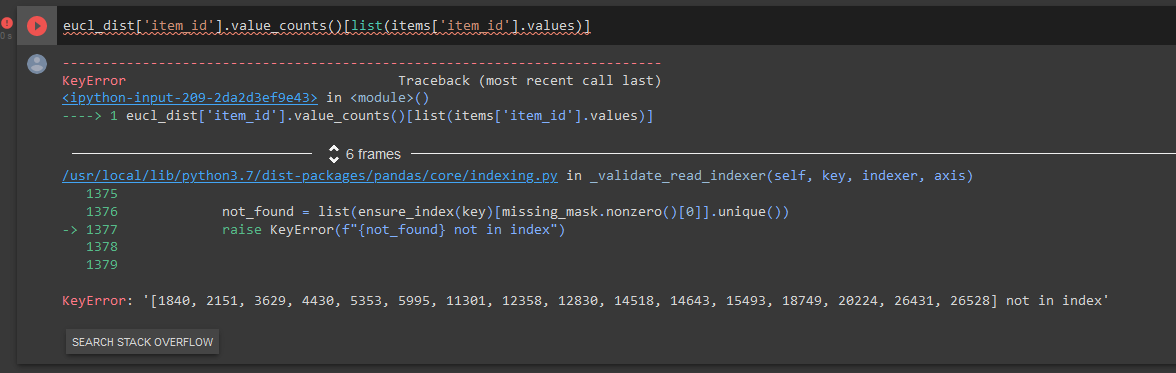

Wird geprüft wie viele der erhaltenen Items aus eucl_dist sich in dem items Datensatz befinden, erhält man 57,77986 %. Damit sind in dieser Vorherssage über die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für eucl_dist 0.02395626959030891 -> ~ 2.4 %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in cosine_dist, so they get removed
o =[1840, 2151, 3629, 4430, 5353, 5995, 11301, 12358, 12830, 14518, 14643, 15493, 18749, 20224, 26431, 26528]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items  
cosine_dist['item_id'].value_counts()[s].sum() / cosine_dist['item_id'].value_counts().sum()*100

Für die weitere Validierung werden aus dem train_sessions Datensatz die ersten 31578  Sessions mit der Kosinusdistanz vorhergesagt und anschließend mit der accuracy_score funktion bewertet.

Zunächst wird eine Matrix aus den ersten 150000 Einträgen des train_session Datensatzes mit den generierten Session Vektoren erstellt.

In [ ]:
cos_val = train_sessions.head(150000).drop('date', axis= 1)
cos_val

,session_id,item_id
0,3,9655
1,3,9655
2,13,15654
3,18,18316
4,18,2507
...,...,...
149995,140778,22371
149996,140778,6175
149997,140778,12242
149998,140778,11856


In [ ]:
Session_Vectors_val = cos_val.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')

In [ ]:
# summarize all vectors from one session 
Session_Vectors_val = Session_Vectors_val.groupby('session_id').sum()
Session_Vectors_val

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
session_id,,,,,,,,,,,,,,,,,,,,,
3,0,106,0,0,0,0,0,0,0,0,...,0,0,0,698,786,0,0,0,0,1088
13,0,0,0,618,0,766,798,0,0,0,...,0,521,0,0,351,780,0,0,219,0
18,1383,0,2379,1854,1815,0,2511,0,0,0,...,0,0,0,0,961,1534,0,0,862,1088
19,0,0,13673,10967,9279,0,7383,0,0,0,...,0,9153,0,0,7223,10360,0,0,4875,6077
24,0,53,0,2472,0,0,4483,0,0,0,...,0,1042,0,349,4265,6041,0,0,2244,2176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140768,0,0,0,2472,0,0,1576,0,0,0,...,0,521,0,0,1062,3220,0,0,300,1088
140770,0,0,0,618,0,0,394,0,0,0,...,0,0,0,0,351,885,0,0,75,544
140771,0,0,793,618,58,0,619,0,0,0,...,0,521,0,0,373,885,0,0,75,544


Anschließend wird ein Validierungsdatensatz aus dem train_purchases Datensatz erstellt

In [ ]:
test_val = train_purchases.head(31578 )
test_val = test_val.drop(['date'], axis=1)
test_val = test_val.set_index(['session_id'])
test_val

,item_id
session_id,
3,15085
13,18626
18,24911
19,12534
24,13226
...,...
140768,27332
140770,15501
140771,17925


In [ ]:
#Map function for validation
def Cosine_dist_val(x):
  q = np.array(Session_Vectors_val[Session_Vectors_val.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(1).index

In [ ]:
%%time
l_val = map(Cosine_dist_val,list(Session_Vectors_val.index))

CPU times: user 3.97 ms, sys: 1 ms, total: 4.97 ms
Wall time: 5.03 ms


In [ ]:
%%time
import functools 
k_val = (functools.reduce(cos_reduce,l_val)) 

CPU times: user 25min 32s, sys: 26.5 s, total: 25min 58s
Wall time: 26min 4s


In [ ]:
k_val

,item_id
0,9655
1,15654
2,16299
3,20528
4,9701
...,...
31573,17541
31574,24228
31575,24467
31576,9626


In [ ]:
# generate the Dataframe for the validation
cosine_dist_val = pd.DataFrame();
cosine_dist_val['session_id'] = train_sessions.head(150000)['session_id'].unique()
cosine_dist_val['item_id'] = k_val
cosine_dist_val = cosine_dist_val.set_index('session_id')
cosine_dist_val

,item_id
session_id,
3,9655
13,15654
18,16299
19,20528
24,9701
...,...
140768,17541
140770,24228
140771,24467


Der errreichte Score beträgt hier lediglich ~ 0,26 %, das liegt aber daran, dass hier für jede Session nur ein Item vorgeschlagen wird und die accuracy_score funktion anwenden zu können.

In [ ]:
accuracy_score(test_val, cosine_dist_val)

0.0026284121856989043



---

### Kosinusdistanz nicht normiert

Zum Vergleich wird hier nocheinmal die identische Vorhersage mit der Kosinusdistanz getätigt, allerdings werden die Vektoren diesmal nicht Normiert.

In [ ]:
#generate the not normalized support matrix
w2 = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w2[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  ii = ii+1
w2 = pd.DataFrame(w2)
w2 = w2.transpose()
w2

,0,1,2,3,4,5,6,7,8,9,...,23681,23682,23683,23684,23685,23686,23687,23688,23689,23690
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0
2,0.0,889.0,793.0,0.0,793.0,793.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,793.0,793.0,0.0,889.0,0.0,0.0
3,0.0,618.0,618.0,0.0,618.0,618.0,0.0,0.0,618.0,0.0,...,618.0,0.0,618.0,618.0,618.0,618.0,0.0,719.0,0.0,0.0
4,0.0,605.0,605.0,0.0,605.0,605.0,0.0,0.0,0.0,472.0,...,0.0,0.0,0.0,0.0,605.0,605.0,0.0,605.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,885.0,592.0,538.0,592.0,592.0,805.0,639.0,805.0,805.0,592.0,...,885.0,592.0,592.0,805.0,885.0,805.0,0.0,499.0,740.0,499.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,226.0,0.0,0.0,0.0
71,75.0,75.0,75.0,75.0,75.0,649.0,75.0,75.0,75.0,219.0,...,75.0,75.0,75.0,75.0,75.0,75.0,0.0,75.0,75.0,371.0


In [ ]:
#euclidean distance nicht normiert
def Cosine_dist2(x):
  q = np.array(Session_Vectors[Session_Vectors.index==x])
  
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w2)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index


In [ ]:
%%time
l2 = (map(Cosine_dist2,list(Session_Vectors.index)))

In [ ]:
%%time

import functools 

k2 = (functools.reduce(cos_reduce,l2)) 

In [ ]:
k2

In [ ]:
# generate the Dataframe for the leaderboard score
cos_dist2 = pd.DataFrame();
cos_dist2['session_id'] = test_leaderboard_sessions['session_id'].unique()
cos_dist2  = cos_dist2.loc[cos_dist2.index.repeat(100)].reset_index(drop=True)
cos_dist2['item_id'] = k2
cos_dist2['rank'] = cos_dist2.groupby('session_id').cumcount()+1
cos_dist2 = cos_dist2.set_index('session_id')
cos_dist2

In [ ]:
cos_dist2.to_csv('cos_dist2.csv')

#### Ergebnisanalyse

Wird geprüft wie viele der erhaltenen Items aus eucl_dist2 sich in dem items Datensatz befinden, erhält man 42,60928 %. Damit sind in dieser Vorherssage weniger als die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für eucl_dist2 0,015383501137446897  -> ~  	1,54  %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in eucl_dist, so they get removed
o =[2937, 3629, 5353, 5995, 8310, 11091, 11301, 12460, 13943, 14643, 20224, 22583, 25791, 26431, 26528, 27103]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items 
cos_dist2['item_id'].value_counts()[s].sum() / cos_dist2['item_id'].value_counts().sum()*100

Auch hier wird der Ansatz wieder mit der accuracy_score funktion validiert.

In [ ]:
#Map function for validation
def Cosine_dist_val2(x):
  q = np.array(Session_Vectors_val[Session_Vectors_val.index==x])
  
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w2)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(1).index

In [ ]:
%%time
l_val2 = map(Cosine_dist_val2,list(Session_Vectors_val.index))

CPU times: user 7.37 ms, sys: 0 ns, total: 7.37 ms
Wall time: 12.4 ms


In [ ]:
%%time
import functools 
k_val2 = (functools.reduce(cos_reduce,l_val2)) 

CPU times: user 24min 53s, sys: 29.6 s, total: 25min 22s
Wall time: 25min 19s


In [ ]:
k_val2

,item_id
0,18256
1,15654
2,19157
3,469
4,9814
...,...
31573,2723
31574,24228
31575,24467
31576,9626


In [ ]:
# generate the Dataframe for the validation
cosine_dist_val2 = pd.DataFrame();
cosine_dist_val2['session_id'] = train_sessions.head(150000)['session_id'].unique()
cosine_dist_val2['item_id'] = k_val2
cosine_dist_val2 = cosine_dist_val2.set_index('session_id')
cosine_dist_val2

,item_id
session_id,
3,18256
13,15654
18,19157
19,469
24,9814
...,...
140768,2723
140770,24228
140771,24467


Der somit erhaltene Score ist hier mit ~ 0,17 % wie erwartet schlechter, als mit den Normierten Vektoren. Das zeigte sich auch bei dem Score, welcher von dem Wettbewerb ausgegeben wurde.


In [ ]:
accuracy_score(test_val, cosine_dist_val2)

0.0016783836848438787



---


### Kosinusdistanz normiert und mit dem Items Datensatz
In diesem Abschnitt wird ein drittes Mal die Kosinusdistanz berechnet. Hier ist der Unterschied, dass die Items der Hilfsmatrix nun aus dem Items Datensatz Stammen und nicht mehr alle Items darin vorhanden sind, sondern nur noch diejenigen, welche tatsächlich gekauft wurden.

In [ ]:
w = np.zeros((len(np.array(test2)),73))
ii = 0
for i in test2.index:
  w[ii] = test2[test2.index==i]
  w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w = pd.DataFrame(w)
w = w.transpose()
w

,0,1,2,3,4,5,6,7,8,9,...,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989
0,0.000000,0.000000,0.000000,0.000000,0.175464,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024383,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022013,0.000000,0.000000
2,0.293068,0.263263,0.270303,0.000000,0.301828,0.281925,0.280596,0.000000,0.272549,0.000000,...,0.295533,0.000000,0.000000,0.279120,0.294761,0.284628,0.000000,0.000000,0.000000,0.000000
3,0.228394,0.205166,0.210653,0.268591,0.235221,0.219709,0.254411,0.000000,0.212403,0.267085,...,0.230315,0.289262,0.307131,0.303407,0.229713,0.221816,0.258825,0.000000,0.292594,0.284162
4,0.223589,0.200850,0.206221,0.000000,0.230273,0.215087,0.214074,0.000000,0.207935,0.000000,...,0.225470,0.000000,0.000000,0.212948,0.059473,0.217150,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.198828,0.196535,0.274394,0.257291,0.044151,0.286191,0.209474,0.000000,0.268081,0.382476,...,0.220625,0.414234,0.439824,0.249554,0.328958,0.317649,0.247936,0.000000,0.419006,0.370146
69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71,0.027718,0.024899,0.221219,0.032596,0.028546,0.026664,0.077491,0.000000,0.025777,0.032413,...,0.027951,0.035105,0.037273,0.026398,0.027878,0.026919,0.002932,0.000000,0.035509,0.034486


In [ ]:
%%time
l = list(map(Cosine_dist,list(Session_Vectors.index)))

CPU times: user 9min 17s, sys: 4min 48s, total: 14min 5s
Wall time: 14min 10s


In [ ]:
%%time
import functools 
k = (functools.reduce(cos_reduce,l)) 

CPU times: user 5min 19s, sys: 28.5 s, total: 5min 47s
Wall time: 5min 46s


In [ ]:
# generate the Dataframe for the leaderboard score
cos_dist3 = pd.DataFrame();
cos_dist3['session_id'] = test_leaderboard_sessions['session_id'].unique()
cos_dist3  = cos_dist3.loc[cos_dist3.index.repeat(100)].reset_index(drop=True)
cos_dist3['item_id'] = k
cos_dist3['rank'] = cos_dist3.groupby('session_id').cumcount()+1
cos_dist3 = cos_dist3.set_index('session_id')
cos_dist3

,item_id,rank
session_id,,
26,19185,1
26,16411,2
26,5199,3
26,5786,4
26,23612,5
...,...,...
4439757,19430,96
4439757,25396,97
4439757,8681,98


In [ ]:
cos_dist3.to_csv('cos_dist3.csv')

Der Score dieses Ansatzes betrug 0.030700678258728336 -> ~3,1%

Damit ist diese Vorhersage noch genauer als die beiden zuvor.

# Maschine learning

## Neuer Abschnitt

In [18]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(pd.DataFrame(normalize(feature_pivtable)), pd.DataFrame(normalize(feature_pivtable)), test_size=0.2, random_state=42)

NameError: ignored

In [ ]:
y_train2.shape

In [ ]:
# Let's say we expect our inputs to be RGB images of arbitrary size
inputs = keras.Input(shape=(73, ))

# Add a dense classifier on top
encoded1  = layers.Dense( 40, activation="relu")(inputs)
encoded2  = layers.Dense( 30, activation="relu")(encoded1)
encoded3  = layers.Dense( 15, activation="relu")(encoded2)

decoded0  = layers.Dense( 35, activation="relu")(encoded3)
decoded  = layers.Dense( 73, activation="softmax")(decoded0)

In [ ]:
autoencoder = keras.Model(inputs, decoded )

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
autoencoder.summary()

In [ ]:
history = autoencoder.fit(X_train2, X_train2,
epochs=100,
batch_size=1000,
shuffle=True,validation_data=(y_test2, y_test2 ))


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])


In [20]:
comprimized['index'] = y_test2.index
comprimized = comprimized.set_index('index')
comprimized

NameError: ignored

In [368]:
Z = autoencoder(feature_pivtable.to_numpy())

In [370]:
z = pd.DataFrame(Z.numpy())
z

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
z[z.index==2].values.sum()

1.0

## Daten präparieren

In [240]:
# Let's say we expect our inputs to be RGB images of arbitrary size
inputs = keras.Input(shape=(73 ))

# Add a dense classifier on top
encoded1  = layers.Dense( 10, activation="relu")(inputs)
#encoded2  = layers.Dense( 35, activation="relu")(encoded1)
#encoded3  = layers.Dense( 10, activation="relu")(encoded2)


In [241]:
autoencoder2 = keras.Model(inputs, encoded1 )
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 73)]              0         
                                                                 
 dense_2 (Dense)             (None, 10)                740       
                                                                 
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


In [242]:
comprimized = autoencoder2(feature_pivtable.to_numpy())

In [243]:
comprimized = pd.DataFrame(normalize(comprimized))
#comprimized = pd.DataFrame(comprimized.numpy())
comprimized

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.880290,0.000000,0.423314,0.171290,0.026936,0.125812,0.0,0.000000
1,0.126030,0.783182,0.000000,0.525104,0.000000,0.266507,0.000000,0.154861,0.0,0.000000
2,0.000000,0.591641,0.323926,0.683047,0.000000,0.139888,0.000000,0.029478,0.0,0.240918
3,0.194175,0.661668,0.062099,0.505456,0.017070,0.395324,0.000000,0.309543,0.0,0.112959
4,0.000000,0.615470,0.186973,0.663994,0.000000,0.000000,0.065853,0.000000,0.0,0.375517
...,...,...,...,...,...,...,...,...,...,...
23686,0.000000,0.938707,0.120821,0.250992,0.000000,0.000000,0.000000,0.164413,0.0,0.119176
23687,0.055901,0.177115,0.906431,0.000000,0.000000,0.000000,0.000000,0.379326,0.0,0.000000
23688,0.000000,0.507442,0.100787,0.219062,0.000000,0.000000,0.000000,0.551681,0.0,0.616445
23689,0.000000,0.359190,0.661349,0.167983,0.536622,0.321718,0.000000,0.117967,0.0,0.000000


In [244]:
comprimized['item_id'] = feature_pivtable.index
comprimized = comprimized.set_index('item_id')

In [245]:
comprimized

,0,1,2,3,4,5,6,7,8,9
item_id,,,,,,,,,,
2,0.000000,0.000000,0.880290,0.000000,0.423314,0.171290,0.026936,0.125812,0.0,0.000000
3,0.126030,0.783182,0.000000,0.525104,0.000000,0.266507,0.000000,0.154861,0.0,0.000000
4,0.000000,0.591641,0.323926,0.683047,0.000000,0.139888,0.000000,0.029478,0.0,0.240918
7,0.194175,0.661668,0.062099,0.505456,0.017070,0.395324,0.000000,0.309543,0.0,0.112959
8,0.000000,0.615470,0.186973,0.663994,0.000000,0.000000,0.065853,0.000000,0.0,0.375517
...,...,...,...,...,...,...,...,...,...,...
28139,0.000000,0.938707,0.120821,0.250992,0.000000,0.000000,0.000000,0.164413,0.0,0.119176
28140,0.055901,0.177115,0.906431,0.000000,0.000000,0.000000,0.000000,0.379326,0.0,0.000000
28141,0.000000,0.507442,0.100787,0.219062,0.000000,0.000000,0.000000,0.551681,0.0,0.616445


In [246]:
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [247]:
X = pd.merge(train_sessions, comprimized, left_on='item_id', right_on='item_id')
X = X.sort_values(by=['session_id','date'])
X

,session_id,item_id,date,0,1,2,3,4,5,6,7,8,9
1,3,9655,2020-12-18 21:19:48.093,0.0,0.349321,0.928479,0.000000,0.000000,0.000000,0.000000,0.126102,0.000000,0.000000
0,3,9655,2020-12-18 21:25:00.373,0.0,0.349321,0.928479,0.000000,0.000000,0.000000,0.000000,0.126102,0.000000,0.000000
117,13,15654,2020-03-13 19:35:27.136,0.0,0.710482,0.399464,0.381170,0.000000,0.372020,0.163358,0.158961,0.000000,0.000000
790,18,4026,2020-08-26 19:15:47.232,0.0,0.508461,0.090679,0.572268,0.000000,0.041831,0.000000,0.446125,0.000000,0.452744
254,18,2507,2020-08-26 19:16:31.211,0.0,0.662109,0.156202,0.493576,0.000000,0.000000,0.000000,0.354143,0.000000,0.410095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656413,4440001,14303,2020-10-30 23:36:17.934,0.0,0.517842,0.000000,0.663329,0.000000,0.000000,0.000000,0.447091,0.000000,0.303220
3778618,4440001,19539,2020-10-30 23:37:09.46,0.0,0.766615,0.481398,0.107755,0.008062,0.130800,0.000000,0.173302,0.000000,0.348911
1656723,4440001,20409,2020-10-30 23:37:20.658,0.0,0.667320,0.588888,0.192705,0.027093,0.073902,0.000000,0.106977,0.000000,0.391305
853151,4440001,27852,2020-10-30 23:39:55.186,0.0,0.749074,0.162419,0.206141,0.000513,0.347083,0.000000,0.464790,0.183075,0.000000


In [248]:
X = X.groupby('session_id').head(5)
X = X.set_index(['session_id', X.groupby('session_id').cumcount()]).unstack()

In [249]:
X

item_id                                      \
                  0        1        2        3        4   
session_id                                                
3            9655.0   9655.0      NaN      NaN      NaN   
13          15654.0      NaN      NaN      NaN      NaN   
18           4026.0   2507.0  18316.0      NaN      NaN   
19          19896.0  27937.0  12804.0  25772.0   6341.0   
24           2927.0   2927.0  16064.0  11662.0    434.0   
...             ...      ...      ...      ...      ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0   
4439994     25357.0      NaN      NaN      NaN      NaN   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0   

                               date                           \
                                  0                        1   
session_id                                                     
3           2020-12-18 21:19:48.093  2020-12-18 21:25:00.373   
13          2020-03-13 19:35:27.136                      NaN   
18          2020-08-26 19:15:47.232  2020-08-26 19:16:31.211   
19          2020-11-02 16:30:36.378  2020-11-02 16:30:48.207   
24          2020-02-26 17:22:48.903   2020-02-26 17:23:04.84   
...                             ...                      ...   
4439986     2021-05-13 11:46:56.606  2021-05-13 11:48:21.792   
4439990     2020-08-22 11:38:48.785  2020-08-22 11:39:20.419   
4439994     2020-11-27 20:08:37.262                      NaN   
4439999     2020-11-27 10:52:12.577  2020-11-27 10:53:09.711   
4440001     2020-10-30 16:42:16.855  2020-10-30 16:42:52.451   

                                                              \
                                  2                        3   
session_id                                                     
3                               NaN                      NaN   
13                              NaN                      NaN   
18          2020-08-26 19:18:30.833                      NaN   
19          2020-11-02 16:31:05.749  2020-11-02 16:31:18.543   
24          2020-02-26 17:26:05.585  2020-02-26 17:26:29.178   
...                             ...                      ...   
4439986     2021-05-13 11:49:19.975  2021-05-13 11:50:51.523   
4439990     2020-08-22 11:39:59.191  2020-08-22 11:40:49.116   
4439994                         NaN                      NaN   
4439999      2020-11-27 10:53:33.83  2020-11-27 10:55:29.549   
4440001      2020-10-30 16:44:09.09  2020-10-30 16:44:15.953   

                                     ...    8                           \
                                  4  ...    0    1         2    3    4   
session_id                           ...                                 
3                               NaN  ...  0.0  0.0       NaN  NaN  NaN   
13                              NaN  ...  0.0  NaN       NaN  NaN  NaN   
18                              NaN  ...  0.0  0.0  0.000000  NaN  NaN   
19          2020-11-02 16:34:33.794  ...  0.0  0.0  0.000000  0.0  0.0   
24          2020-02-26 17:27:11.894  ...  0.0  0.0  0.000000  0.0  0.0   
...                             ...  ...  ...  ...       ...  ...  ...   
4439986     2021-05-13 11:53:36.222  ...  0.0  0.0  0.000000  0.0  0.0   
4439990     2020-08-22 11:42:19.866  ...  0.0  0.0  0.000000  0.0  0.0   
4439994                         NaN  ...  0.0  NaN       NaN  NaN  NaN   
4439999     2020-11-27 10:56:04.417  ...  0.0  0.0  0.015323  0.0  0.0   
4440001     2020-10-30 23:24:55.227  ...  0.0  0.0  0.000000  0.0  0.0   

                   9                                          
                   0         1         2         3         4  
session_id                                                    
3           0.000000  0.000000       NaN       NaN       NaN  
13          0.000000       NaN       NaN       NaN       NaN  
18          0.452744  0.410095  0.10532

In [250]:
X.fillna(0)

item_id                                      \
                  0        1        2        3        4   
session_id                                                
3            9655.0   9655.0      0.0      0.0      0.0   
13          15654.0      0.0      0.0      0.0      0.0   
18           4026.0   2507.0  18316.0      0.0      0.0   
19          19896.0  27937.0  12804.0  25772.0   6341.0   
24           2927.0   2927.0  16064.0  11662.0    434.0   
...             ...      ...      ...      ...      ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0   
4439994     25357.0      0.0      0.0      0.0      0.0   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0   

                               date                           \
                                  0                        1   
session_id                                                     
3           2020-12-18 21:19:48.093  2020-12-18 21:25:00.373   
13          2020-03-13 19:35:27.136                        0   
18          2020-08-26 19:15:47.232  2020-08-26 19:16:31.211   
19          2020-11-02 16:30:36.378  2020-11-02 16:30:48.207   
24          2020-02-26 17:22:48.903   2020-02-26 17:23:04.84   
...                             ...                      ...   
4439986     2021-05-13 11:46:56.606  2021-05-13 11:48:21.792   
4439990     2020-08-22 11:38:48.785  2020-08-22 11:39:20.419   
4439994     2020-11-27 20:08:37.262                        0   
4439999     2020-11-27 10:52:12.577  2020-11-27 10:53:09.711   
4440001     2020-10-30 16:42:16.855  2020-10-30 16:42:52.451   

                                                              \
                                  2                        3   
session_id                                                     
3                                 0                        0   
13                                0                        0   
18          2020-08-26 19:18:30.833                        0   
19          2020-11-02 16:31:05.749  2020-11-02 16:31:18.543   
24          2020-02-26 17:26:05.585  2020-02-26 17:26:29.178   
...                             ...                      ...   
4439986     2021-05-13 11:49:19.975  2021-05-13 11:50:51.523   
4439990     2020-08-22 11:39:59.191  2020-08-22 11:40:49.116   
4439994                           0                        0   
4439999      2020-11-27 10:53:33.83  2020-11-27 10:55:29.549   
4440001      2020-10-30 16:44:09.09  2020-10-30 16:44:15.953   

                                     ...    8                           \
                                  4  ...    0    1         2    3    4   
session_id                           ...                                 
3                                 0  ...  0.0  0.0  0.000000  0.0  0.0   
13                                0  ...  0.0  0.0  0.000000  0.0  0.0   
18                                0  ...  0.0  0.0  0.000000  0.0  0.0   
19          2020-11-02 16:34:33.794  ...  0.0  0.0  0.000000  0.0  0.0   
24          2020-02-26 17:27:11.894  ...  0.0  0.0  0.000000  0.0  0.0   
...                             ...  ...  ...  ...       ...  ...  ...   
4439986     2021-05-13 11:53:36.222  ...  0.0  0.0  0.000000  0.0  0.0   
4439990     2020-08-22 11:42:19.866  ...  0.0  0.0  0.000000  0.0  0.0   
4439994                           0  ...  0.0  0.0  0.000000  0.0  0.0   
4439999     2020-11-27 10:56:04.417  ...  0.0  0.0  0.015323  0.0  0.0   
4440001     2020-10-30 23:24:55.227  ...  0.0  0.0  0.000000  0.0  0.0   

                   9                                          
                   0         1         2         3         4  
session_id                                                    
3           0.000000  0.000000  0.000000  0.000000  0.000000  
13          0.000000  0.000000  0.000000  0.000000  0.000000  
18          0.452744  0.410095  0.10532

In [251]:
import datetime as dt

In [252]:
x_date = X.date

In [253]:
x_date = x_date.fillna(0)
x_date

,0,1,2,3,4
session_id,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,0,0,0
13,2020-03-13 19:35:27.136,0,0,0,0
18,2020-08-26 19:15:47.232,2020-08-26 19:16:31.211,2020-08-26 19:18:30.833,0,0
19,2020-11-02 16:30:36.378,2020-11-02 16:30:48.207,2020-11-02 16:31:05.749,2020-11-02 16:31:18.543,2020-11-02 16:34:33.794
24,2020-02-26 17:22:48.903,2020-02-26 17:23:04.84,2020-02-26 17:26:05.585,2020-02-26 17:26:29.178,2020-02-26 17:27:11.894
...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:48:21.792,2021-05-13 11:49:19.975,2021-05-13 11:50:51.523,2021-05-13 11:53:36.222
4439990,2020-08-22 11:38:48.785,2020-08-22 11:39:20.419,2020-08-22 11:39:59.191,2020-08-22 11:40:49.116,2020-08-22 11:42:19.866
4439994,2020-11-27 20:08:37.262,0,0,0,0


In [254]:
for i in range(5):
  x_date[i] = pd.to_datetime(x_date[i]).astype(np.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


In [255]:
x_date

,0,1,2,3,4
session_id,,,,,
3,1608326388093000000,1608326700373000000,0,0,0
13,1584128127136000000,0,0,0,0
18,1598469347232000000,1598469391211000000,1598469510833000000,0,0
19,1604334636378000000,1604334648207000000,1604334665749000000,1604334678543000000,1604334873794000000
24,1582737768903000000,1582737784840000000,1582737965585000000,1582737989178000000,1582738031894000000
...,...,...,...,...,...
4439986,1620906416606000000,1620906501792000000,1620906559975000000,1620906651523000000,1620906816222000000
4439990,1598096328785000000,1598096360419000000,1598096399191000000,1598096449116000000,1598096539866000000
4439994,1606507717262000000,0,0,0,0


In [256]:
X.date = x_date
X
X = X.fillna(0)

In [257]:
X

item_id                                                     date  \
                  0        1        2        3        4                    0   
session_id                                                                     
3            9655.0   9655.0      0.0      0.0      0.0  1608326388093000000   
13          15654.0      0.0      0.0      0.0      0.0  1584128127136000000   
18           4026.0   2507.0  18316.0      0.0      0.0  1598469347232000000   
19          19896.0  27937.0  12804.0  25772.0   6341.0  1604334636378000000   
24           2927.0   2927.0  16064.0  11662.0    434.0  1582737768903000000   
...             ...      ...      ...      ...      ...                  ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0  1620906416606000000   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0  1598096328785000000   
4439994     25357.0      0.0      0.0      0.0      0.0  1606507717262000000   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0  1606474332577000000   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0  1604076136855000000   

                                                                           \
                              1                    2                    3   
session_id                                                                  
3           1608326700373000000                    0                    0   
13                            0                    0                    0   
18          1598469391211000000  1598469510833000000                    0   
19          1604334648207000000  1604334665749000000  1604334678543000000   
24          1582737784840000000  1582737965585000000  1582737989178000000   
...                         ...                  ...                  ...   
4439986     1620906501792000000  1620906559975000000  1620906651523000000   
4439990     1598096360419000000  1598096399191000000  1598096449116000000   
4439994                       0                    0                    0   
4439999     1606474389711000000  1606474413830000000  1606474529549000000   
4440001     1604076172451000000  1604076249090000000  1604076255953000000   

                                 ...    8                                  9  \
                              4  ...    0    1         2    3    4         0   
session_id                       ...                                           
3                             0  ...  0.0  0.0  0.000000  0.0  0.0  0.000000   
13                            0  ...  0.0  0.0  0.000000  0.0  0.0  0.000000   
18                            0  ...  0.0  0.0  0.000000  0.0  0.0  0.452744   
19          1604334873794000000  ...  0.0  0.0  0.000000  0.0  0.0  0.195717   
24          1582738031894000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000   
...                         ...  ...  ...  ...       ...  ...  ...       ...   
4439986     1620906816222000000  ...  0.0  0.0  0.000000  0.0  0.0  0.399508   
4439990     1598096539866000000  ...  0.0  0.0  0.000000  0.0  0.0  0.195749   
4439994                       0  ...  0.0  0.0  0.000000  0.0  0.0  0.007095   
4439999     1606474564417000000  ...  0.0  0.0  0.015323  0.0  0.0  0.245321   
4440001     1604100295227000000  ...  0.0  0.0  0.000000  0.0  0.0  0.335967   

                                                    
                   1         2         3         4  
session_id                                          
3           0.000000  0.000000  0.000000  0.000000  
13          0.000000  0.000000  0.000000  0.000000  
18          0.410095  0.105320  0.000000  0.000000  
19          0.165033  0.149625  0.391172  0.234995  
24          0.000000  0.279755  0.000000  0.181258  
...              ...       ...       ...       ...  
4439986     0.408504  0.393100  0.473765  0.412767  
4439990     0.136492  0.083362  0.209880  0.030182  
4439994     0.000000  0.000000  0.000000  0.000000  
4439999     0.301670  0.280140  0.455951  0.234580  
44

In [258]:
y = train_purchases

In [259]:
y = y.set_index('session_id')
y.date = pd.to_datetime(y.date).astype(np.int64)
y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


,item_id,date
session_id,,
3,15085,1608326807986000000
13,18626,1584128175507000000
18,24911,1598469632049000000
19,12534,1604337405920000000
24,13226,1582741664114000000
...,...,...
4439986,2915,1620906997464000000
4439990,8786,1598106502382000000
4439994,21630,1606507828961000000


Päparieren des test_leaderboard_sessions Datensatz

In [260]:
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


In [261]:
X_pred = pd.merge(test_leaderboard_sessions, comprimized, left_on='item_id', right_on='item_id')
X_pred = X_pred.sort_values(by=['session_id','date'])
X_pred

,session_id,item_id,date,0,1,2,3,4,5,6,7,8,9
0,26,19185,2021-06-16 09:53:54.158,0.0,0.828256,0.277656,0.434498,0.000000,0.000000,0.0,0.054663,0.0,0.212420
16,200,17089,2021-06-25 12:23:40.811,0.0,0.766615,0.481398,0.107755,0.008062,0.130800,0.0,0.173302,0.0,0.348911
17,200,17089,2021-06-25 12:24:36.631,0.0,0.766615,0.481398,0.107755,0.008062,0.130800,0.0,0.173302,0.0,0.348911
418,200,8060,2021-06-25 12:24:41.677,0.0,0.842992,0.411260,0.159738,0.073779,0.000000,0.0,0.168851,0.0,0.246492
1507,200,4758,2021-06-25 12:24:50.692,0.0,0.817580,0.312013,0.098757,0.167285,0.211011,0.0,0.308726,0.0,0.237985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106453,4439653,25955,2021-06-11 10:22:57.47,0.0,0.494112,0.660014,0.000000,0.212894,0.139493,0.0,0.269170,0.0,0.427786
66502,4439653,12179,2021-06-11 10:23:00.663,0.0,0.572203,0.521477,0.000000,0.332158,0.168810,0.0,0.359669,0.0,0.363947
163138,4439757,2078,2021-06-30 11:42:15.073,0.0,0.679788,0.000000,0.414017,0.000000,0.000000,0.0,0.397057,0.0,0.456974
163139,4439757,2078,2021-06-30 11:43:13.725,0.0,0.679788,0.000000,0.414017,0.000000,0.000000,0.0,0.397057,0.0,0.456974


In [262]:
X_pred = X_pred.groupby('session_id').head(5)
X_pred = X_pred.set_index(['session_id', X_pred.groupby('session_id').cumcount()]).unstack()
X_pred = X_pred.fillna(0)
X_pred

item_id                                     \
                  0        1        2       3        4   
session_id                                               
26          19185.0      0.0      0.0     0.0      0.0   
200         17089.0  17089.0   8060.0  4758.0      0.0   
205          8194.0      0.0      0.0     0.0      0.0   
495          6853.0      0.0      0.0     0.0      0.0   
521         26471.0      0.0      0.0     0.0      0.0   
...             ...      ...      ...     ...      ...   
4439446     20770.0  20770.0  21396.0     0.0      0.0   
4439458     11715.0  26499.0      0.0     0.0      0.0   
4439550     19086.0      0.0      0.0     0.0      0.0   
4439653      4813.0  14075.0  14075.0  4813.0  12179.0   
4439757      2078.0   2078.0   6790.0     0.0      0.0   

                               date                           \
                                  0                        1   
session_id                                                     
26          2021-06-16 09:53:54.158                        0   
200         2021-06-25 12:23:40.811  2021-06-25 12:24:36.631   
205         2021-06-11 00:28:07.058                        0   
495         2021-06-14 22:13:06.741                        0   
521          2021-06-19 13:50:03.09                        0   
...                             ...                      ...   
4439446     2021-06-11 17:16:12.243  2021-06-11 17:16:19.713   
4439458     2021-06-09 04:52:02.785  2021-06-09 04:54:45.378   
4439550     2021-06-02 17:42:40.481                        0   
4439653     2021-06-11 10:19:35.472  2021-06-11 10:19:39.093   
4439757     2021-06-30 11:42:15.073  2021-06-30 11:43:13.725   

                                                              \
                                  2                        3   
session_id                                                     
26                                0                        0   
200         2021-06-25 12:24:41.677  2021-06-25 12:24:50.692   
205                               0                        0   
495                               0                        0   
521                               0                        0   
...                             ...                      ...   
4439446     2021-06-11 17:17:11.565                        0   
4439458                           0                        0   
4439550                           0                        0   
4439653     2021-06-11 10:19:40.696  2021-06-11 10:19:42.858   
4439757     2021-06-30 11:44:52.704                        0   

                                     ...    8                             9  \
                                  4  ...    0    1    2    3    4         0   
session_id                           ...                                      
26                                0  ...  0.0  0.0  0.0  0.0  0.0  0.212420   
200                               0  ...  0.0  0.0  0.0  0.0  0.0  0.348911   
205                               0  ...  0.0  0.0  0.0  0.0  0.0  0.161677   
495                               0  ...  0.0  0.0  0.0  0.0  0.0  0.000000   
521                               0  ...  0.0  0.0  0.0  0.0  0.0  0.302495   
...                             ...  ...  ...  ...  ...  ...  ...       ...   
4439446                           0  ...  0.0  0.0  0.0  0.0  0.0  0.347103   
4439458                           0  ...  0.0  0.0  0.0  0.0  0.0  0.000000   
4439550                           0  ...  0.0  0.0  0.0  0.0  0.0  0.365794   
4439653     2021-06-11 10:22:42.956  ...  0.0  0.0  0.0  0.0  0.0  0.433771   
4439757                           0  ...  0.0  0.0  0.0  0.0  0.0  0.456974   

                                                    
                   1         2         3         4  
session_id                                          
26          0.000000  0.000000  0.000000  0.000000  
200         0.348911  0.246492  0.237985  0.000000  
205         0.000000  0.000000  0

In [263]:
x_pred_date = X_pred.date
for i in range(5):
  x_pred_date[i] = pd.to_datetime(x_pred_date[i]).astype(np.int64)
X_pred.date = x_pred_date

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [264]:
X_pred

item_id                                                    date  \
                  0        1        2       3        4                    0   
session_id                                                                    
26          19185.0      0.0      0.0     0.0      0.0  1623837234158000000   
200         17089.0  17089.0   8060.0  4758.0      0.0  1624623820811000000   
205          8194.0      0.0      0.0     0.0      0.0  1623371287058000000   
495          6853.0      0.0      0.0     0.0      0.0  1623708786741000000   
521         26471.0      0.0      0.0     0.0      0.0  1624110603090000000   
...             ...      ...      ...     ...      ...                  ...   
4439446     20770.0  20770.0  21396.0     0.0      0.0  1623431772243000000   
4439458     11715.0  26499.0      0.0     0.0      0.0  1623214322785000000   
4439550     19086.0      0.0      0.0     0.0      0.0  1622655760481000000   
4439653      4813.0  14075.0  14075.0  4813.0  12179.0  1623406775472000000   
4439757      2078.0   2078.0   6790.0     0.0      0.0  1625053335073000000   

                                                                           \
                              1                    2                    3   
session_id                                                                  
26                            0                    0                    0   
200         1624623876631000000  1624623881677000000  1624623890692000000   
205                           0                    0                    0   
495                           0                    0                    0   
521                           0                    0                    0   
...                         ...                  ...                  ...   
4439446     1623431779713000000  1623431831565000000                    0   
4439458     1623214485378000000                    0                    0   
4439550                       0                    0                    0   
4439653     1623406779093000000  1623406780696000000  1623406782858000000   
4439757     1625053393725000000  1625053492704000000                    0   

                                 ...    8                             9  \
                              4  ...    0    1    2    3    4         0   
session_id                       ...                                      
26                            0  ...  0.0  0.0  0.0  0.0  0.0  0.212420   
200                           0  ...  0.0  0.0  0.0  0.0  0.0  0.348911   
205                           0  ...  0.0  0.0  0.0  0.0  0.0  0.161677   
495                           0  ...  0.0  0.0  0.0  0.0  0.0  0.000000   
521                           0  ...  0.0  0.0  0.0  0.0  0.0  0.302495   
...                         ...  ...  ...  ...  ...  ...  ...       ...   
4439446                       0  ...  0.0  0.0  0.0  0.0  0.0  0.347103   
4439458                       0  ...  0.0  0.0  0.0  0.0  0.0  0.000000   
4439550                       0  ...  0.0  0.0  0.0  0.0  0.0  0.365794   
4439653     1623406962956000000  ...  0.0  0.0  0.0  0.0  0.0  0.433771   
4439757                       0  ...  0.0  0.0  0.0  0.0  0.0  0.456974   

                                                    
                   1         2         3         4  
session_id                                          
26          0.000000  0.000000  0.000000  0.000000  
200         0.348911  0.246492  0.237985  0.000000  
205         0.000000  0.000000  0.000000  0.000000  
495         0.000000  0.000000  0.000000  0.000000  
521         0.000000  0.000000  0.000000  0.000000  
...              ...       ...       ...       ...  
4439446     0.347103  0.317885  0.000000  0.000000  
4439458     0.085344  0.000000  0.000000  0.000000  
4439550     0.000000  0.000000  0.000000  0.000000  
4439653     0.369253  0.369253  0.433771  0.363947  
4439757     0.456974  0.427109  0.000000  0.000000  

[50000 rows x 60 columns]

## Modell trainieren und eine Vorhersage treffen lassen

In [ ]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:


# install 
!pip install scikit-optimize



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_squared_error



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%time
RFR =RandomForestRegressor(n_jobs=-1, n_estimators=100)
RFR.fit(X_train,y_train)
print(RFR.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.46449833357135656
CPU times: user 1h 11min 20s, sys: 13.7 s, total: 1h 11min 33s
Wall time: 36min 56s


In [ ]:
RFR_pred = RFR.predict(X_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
RFR_pred = pd.DataFrame(RFR_pred)

In [ ]:
RFR_pred = RFR_pred.round(0)
RFR_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
RFR_pred['item_id'] = RFR_pred[0]
RFR_pred['rank'] = 1
RFR_pred = RFR_pred.set_index('session_id')
RFR_pred

,0,1,item_id,rank
session_id,,,,
26,14843.0,1.622504e+18,14843.0,1
200,16002.0,1.622504e+18,16002.0,1
205,14034.0,1.622503e+18,14034.0,1
495,12516.0,1.622503e+18,12516.0,1
521,13342.0,1.622503e+18,13342.0,1
...,...,...,...,...
4439446,16177.0,1.622504e+18,16177.0,1
4439458,16394.0,1.622504e+18,16394.0,1
4439550,13748.0,1.622503e+18,13748.0,1


In [ ]:
RFR_pred = RFR_pred.drop([0,1], axis=1)

In [ ]:
RFR_pred

,item_id,rank
session_id,,
26,14843.0,1
200,16002.0,1
205,14034.0,1
495,12516.0,1
521,13342.0,1
...,...,...
4439446,16177.0,1
4439458,16394.0,1
4439550,13748.0,1


In [ ]:

rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

RFR_pred['item_id'] = pd.cut(RFR_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])
RFR_pred

,item_id,rank
session_id,,
26,14857,1
200,16003,1
205,14040,1
495,12524,1
521,13344,1
...,...,...
4439446,16178,1
4439458,16398,1
4439550,13749,1


In [ ]:
RFR_pred.to_csv('RFR_pred.csv')

## Daten ohne Zeitstempel präparieren
Zum Vergleich wird der Identische Ansatz erneut angewendet, diesmal allerdings ohne den Zeitstempel.

In [265]:
X2 = X.drop(['date'], axis=1)
X2

item_id                                        0                 \
                  0        1        2        3        4    0    1    2    3   
session_id                                                                    
3            9655.0   9655.0      0.0      0.0      0.0  0.0  0.0  0.0  0.0   
13          15654.0      0.0      0.0      0.0      0.0  0.0  0.0  0.0  0.0   
18           4026.0   2507.0  18316.0      0.0      0.0  0.0  0.0  0.0  0.0   
19          19896.0  27937.0  12804.0  25772.0   6341.0  0.0  0.0  0.0  0.0   
24           2927.0   2927.0  16064.0  11662.0    434.0  0.0  0.0  0.0  0.0   
...             ...      ...      ...      ...      ...  ...  ...  ...  ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0  0.0  0.0  0.0  0.0   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0  0.0  0.0  0.0  0.0   
4439994     25357.0      0.0      0.0      0.0      0.0  0.0  0.0  0.0  0.0   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0  0.0  0.0  0.0  0.0   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0  0.0  0.0  0.0  0.0   

                      ...    8                                  9            \
                   4  ...    0    1         2    3    4         0         1   
session_id            ...                                                     
3           0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
13          0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
18          0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.452744  0.410095   
19          0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.195717  0.165033   
24          0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
...              ...  ...  ...  ...       ...  ...  ...       ...       ...   
4439986     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.399508  0.408504   
4439990     0.025462  ...  0.0  0.0  0.000000  0.0  0.0  0.195749  0.136492   
4439994     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.007095  0.000000   
4439999     0.000000  ...  0.0  0.0  0.015323  0.0  0.0  0.245321  0.301670   
4440001     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.335967  0.267047   

                                          
                   2         3         4  
session_id                                
3           0.000000  0.000000  0.000000  
13          0.000000  0.000000  0.000000  
18          0.105320  0.000000  0.000000  
19          0.149625  0.391172  0.234995  
24          0.279755  0.000000  0.181258  
...              ...       ...       ...  
4439986     0.393100  0.473765  0.412767  
4439990     0.083362  0.209880  0.030182  
4439994     0.000000  0.000000  0.000000  
4439999     0.280140  0.455951  0.234580  
4440001     0.230315  0.319331  0.335967  

[1000000 rows x 55 columns]

In [266]:
y2 = y.drop(['date'], axis=1)
y2

,item_id
session_id,
3,15085
13,18626
18,24911
19,12534
24,13226
...,...
4439986,2915
4439990,8786
4439994,21630


In [267]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4, random_state=42)

In [268]:
X_pred2 = X_pred.drop(['date'], axis=1)

## Erneutes trainieren und vorhersagen ohne Zeitstempel

In [98]:
%%time
#RFR = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, n_estimators=100) ) 
RFR = RandomForestRegressor(n_jobs=-1, n_estimators=100)
RFR.fit(X_train2.head(5000),y_train2.head(5000))
print(RFR.score(X_test2,y_test2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


-0.05597942110188381
CPU times: user 29.5 s, sys: 85.4 ms, total: 29.6 s
Wall time: 23.2 s


In [72]:
RFR.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

<BarContainer object of 55 artists>

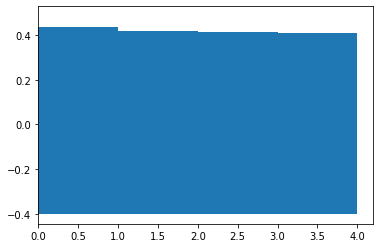

In [99]:
plt.barh(RFR.feature_importances_,pd.DataFrame(list(X_train2.columns.values[:]))[1])

In [75]:
import time
import numpy as np

start_time = time.time()
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.124 seconds


In [76]:

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

NameError: ignored

In [ ]:
RFR_pred2 = RFR.predict(X_pred2)
RFR_pred2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


array([17489.71488095, 13405.53      , 14629.50964286, ...,
       15309.13      , 13782.35      ,  7481.97152381])

In [ ]:
RFR_pred2 = pd.DataFrame(RFR_pred2)
RFR_pred2.columns=['item_id']
RFR_pred2

,item_id
0,17489.714881
1,13405.530000
2,14629.509643
3,14341.188000
4,13296.122705
...,...
399995,13406.309500
399996,14248.710000
399997,15309.130000
399998,13782.350000


In [ ]:
rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

RFR_pred2['item_id'] = pd.cut(RFR_pred2['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])
RFR_pred2

,item_id
0,17502
1,13408
2,14635
3,14343
4,13299
...,...
399995,13408
399996,14251
399997,15319
399998,13788


In [ ]:
RFR_pred2['session_id'] = test_leaderboard_sessions['session_id'].unique()
RFR_pred2['rank'] = 1
RFR_pred2 = RFR_pred2.set_index('session_id')
RFR_pred2

,item_id,rank
session_id,,
26,14017,1
200,10909,1
205,20840,1
495,14447,1
521,12115,1
...,...,...
4439446,11939,1
4439458,11663,1
4439550,16427,1


In [ ]:
RFR_pred2.to_csv('RFR_pred2.csv')

In [ ]:
# calculate the loss
from sklearn.metrics import log_loss

In [ ]:
rf_loss = log_loss(y_test2.head(20000), RFR_pred2.head(20000))
print(rf_loss)

In [ ]:
stop

In [ ]:
# initiate optimizer
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=.9, decay=1e-6)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [ ]:
normalizer = Normalization(axis=-1)
normalizer.adapt(X)

normalized_X = normalizer(X)
print("var: %.4f" % np.var(normalized_X))
print("mean: %.4f" % np.mean(normalized_X))

normalizer = Normalization(axis=-1)
normalizer.adapt(y)

normalized_y = normalizer(y)
print("var: %.4f" % np.var(normalized_y))
print("mean: %.4f" % np.mean(normalized_y))

In [ ]:
stop

## MLP regressor

In [ ]:
%%time
from sklearn.neural_network import MLPRegressor

regr = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=500)).fit(X_train2,y_train2)
regr.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/p

CPU times: user 40min 14s, sys: 28min 16s, total: 1h 8min 30s
Wall time: 35min 15s


In [ ]:
regr.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.0008581822762189217

In [ ]:
MLP_pred = regr.predict(X_test2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
MLP_pred = pd.DataFrame(MLP_pred)
MLP_pred.columns=['item_id']

rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

MLP_pred['item_id'] = pd.cut(MLP_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

MLP_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
MLP_pred['rank'] = 1
MLP_pred = MLP_pred.set_index('session_id')
MLP_pred

,item_id,rank
session_id,,
26,12901,1
200,12508,1
205,13389,1
495,12621,1
521,13333,1
...,...,...
4439446,12621,1
4439458,14961,1
4439550,13160,1


In [ ]:
MLP_pred.to_csv('MLP_pred.csv')

In [ ]:
#Normalize Data
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X2[0])  # fit does nothing.
t = pd.DataFrame(transformer.transform(X2[0]))
t['session_id'] = list(X.index)
t = t.set_index('session_id')
X2[0] = t

In [ ]:
t

,0,1,2,3,4
session_id,,,,,
3,0.000000,0.000000,0.000000,0.000000,0.000000
13,1.000000,0.000000,0.000000,0.000000,0.000000
18,0.872717,0.260541,0.412898,0.000000,0.000000
19,0.604646,0.444258,0.435582,0.303952,0.393598
24,0.592629,0.592629,0.232137,0.000000,0.493654
...,...,...,...,...,...
4439986,0.000000,0.000000,0.000000,0.000000,0.000000
4439990,0.318062,0.591231,0.637101,0.365679,0.098302
4439994,1.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
MLP_pred = regr.predict(X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
MLP_pred = pd.DataFrame(MLP_pred)
MLP_pred.columns=['item_id']

rounding_logic = pd.Series(features['item_id'].unique())
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

MLP_pred['item_id'] = pd.cut(MLP_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

MLP_pred['session_id'] = X_test2.index
#MLP_pred['rank'] = 1
MLP_pred = MLP_pred.set_index('session_id')
MLP_pred

,item_id
session_id,
4383345,14279
357505,13887
2517256,14459
2224118,13767
246261,14093
...,...
490658,13697
1886216,14025
4094052,13818


In [ ]:
accuracy_score(y_test2, MLP_pred)

5e-05

In [ ]:
log_loss(y_test2, MLP_pred)

## SVC

In [ ]:
y_train2 = y_train2.sort_index()
X_train2 = X_train2.sort_index()

In [ ]:


#regr = MLPRegressor
regr = make_pipeline(StandardScaler(), MLPRegressor())
#clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(regr,X_train2,y_train2, cv=5, n_jobs=-1)
scores

array([0.00017574, 0.00019685, 0.00013661, 0.00028945, 0.00059555])

In [ ]:
regr = make_pipeline(StandardScaler(), MLPRegressor())
regr.fit(X_train2,y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor())])

In [ ]:
regr.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.0007650179223158693

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
svm = make_pipeline(StandardScaler(), SVC() )#rbf is default kernel


In [ ]:
svm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [ ]:
parameters = dict(svc__C=[0.1,1,2,5,10,100],svc__gamma=[10,5, 1,0.1,'scale']) #create search space
search = RandomizedSearchCV(svm, parameters, n_jobs=-1,n_iter=20, cv=5,random_state=0)

In [ ]:
y_train2.head(100)

,item_id
session_id,
13,18626
18,24911
19,12534
24,13226
28,26394
...,...
815,1367
817,8290
829,14510


In [ ]:
res=search.fit(X_train2.head(1000),y_train2.head(1000)) #use subset of the date to speed things up (use full data for real experiment!)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
res.best_params_

{'svc__C': 2, 'svc__gamma': 10}

In [ ]:
res.best_score_

0.01

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(C=2,gamma=10) )

In [ ]:
svm.fit(X_train2,y_train2)

In [ ]:
svm.score(X_test2, y_test2)

## Neuer Abschnitt

In [ ]:
from sklearn.neural_network import MLPClassifier

#mit random forest clasificator testen
mlpcl = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=500) )
mlpcl.fit(X_train2.head(50000),y_train2.head(50000))
mlpcl.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.

In [ ]:
mlpcl.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'mlpregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'mlpregressor__activation', 'mlpregressor__alpha', 'mlpregressor__batch_size', 'mlpregressor__beta_1', 'mlpregressor__beta_2', 'mlpregressor__early_stopping', 'mlpregressor__epsilon', 'mlpregressor__hidden_layer_sizes', 'mlpregressor__learning_rate', 'mlpregressor__learning_rate_init', 'mlpregressor__max_fun', 'mlpregressor__max_iter', 'mlpregressor__momentum', 'mlpregressor__n_iter_no_change', 'mlpregressor__nesterovs_momentum', 'mlpregressor__power_t', 'mlpregressor__random_state', 'mlpregressor__shuffle', 'mlpregressor__solver', 'mlpregressor__tol', 'mlpregressor__validation_fraction', 'mlpregressor__verbose', 'mlpregressor__warm_start'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.22 GB -- Worker memory limit: 13.62 GB


In [ ]:
%%time
RFC =RandomForestClassifier(n_jobs=-1)

with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    RFC.fit(X_train2,y_train2)
print(RFC.score(X_test2,y_test2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.22 GB -- Worker memory limit: 13.62 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.23 GB -- Worker memory limit: 10.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.25 GB -- Worker memory limit: 13.62 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.20 GB -- Worker m

KeyboardInterrupt: ignored

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 10.95 GB -- Worker memory limit: 10.00 GB


In [ ]:
RFC.fit(X_train2.tail(100),y_train2.tail(100))
print(RFC.score(X_test2,y_test2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.0017675


In [ ]:
RFC2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=6) )

NameError: ignored

In [ ]:
RFC2.fit(X_train2.head(2000).astype('int'),y_train2.head(2000))
RFC2.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
RFC2.fit(X_train2.tail(500),y_train2.tail(500))
RFC2.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist

## xgboost

In [27]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


In [ ]:
ranker = xgb.XGBRFClassifier(n_jobs=-1,max_depth =6,n_estimators=50)

In [86]:
ranker = xgb.XGBRegressor(n_jobs=-1)

In [ ]:
y_train2.head(10000)['item_id'].nunique()#[y_train2['item_id']==8060]

5623

In [ ]:
from dask_ml.xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/dask_xgboost/__init__.py:8: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  "Dask-XGBoost has been deprecated and is no longer maintained. The functionality "


In [ ]:
ranker = XGBClassifier(n_jobs=-1,max_depth =6,n_estimators=50)

In [87]:
ranker.fit(X_train2.astype('int'),y_train2)

[10:16:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [ ]:
%%time
with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    ranker.fit(X_train2.head(25000).astype('int'),y_train2.head(25000))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 7.00 GB -- Worker memory limit: 10.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 7.00 GB -- Worker memory limit: 10.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to sto

In [ ]:
g = ranker.predict(X_pred2)

In [ ]:
g = pd.DataFrame(g)
g['item_id'] = g[0]
g = g.drop(columns=[0])
g

,item_id
0,13980.474609
1,14178.340820
2,14254.378906
3,13628.359375
4,13923.510742
...,...
49995,13912.248047
49996,13988.181641
49997,13937.369141
49998,14271.941406


In [ ]:
rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

g['item_id'] = pd.cut(g['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])
g['rank'] = 1
g['session_id'] = test_leaderboard_sessions['session_id'].unique()
g = g.set_index('session_id')
g

,item_id,rank
session_id,,
26,13986,1
200,14180,1
205,14261,1
495,13630,1
521,13936,1
...,...,...
4439446,13913,1
4439458,13994,1
4439550,13943,1


In [ ]:
g.to_csv('XGBRegressor.csv')

In [88]:
ranker.score(X_test2,y_test2)

-0.008754466688577489

In [ ]:
from sklearn.metrics import mean_absolute_error

reg = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)
reg.fit(X_train2.head(2000).astype('int'),y_train2.head(2000), eval_set=[(X_test2, y_test2)])

XGBoostError: ignored

In [ ]:
# read in data
dtrain = xgb.DMatrix(X_test2.head(100), missing=np.NaN)
dtest = xgb.DMatrix(X_pred2.head(100), missing=np.NaN)


In [ ]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

XGBoostError: ignored

In [ ]:
# calculate the loss
from sklearn.metrics import log_loss
y_predicted = RFC2.predict_proba(X_pred2)
rf_loss = log_loss(y_test2.head(50000), y_predicted)
print(rf_loss)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


ValueError: ignored

## DASK

Damit ein Classifier verwendet werden kann, muss die RAM-Auslastung reduziert werden. Als ersten Schritt wurde dafür nur die Sessions mit den x beliebtesten Items behalten werden.

mit 1000 beliebtesten Items ohne RAM überlauf möglich erreichter Score 0.08708432010933008 -> ~8,71 %

Mit den 2500 beliebtesten Items in kombination eines lokalen Dask clients konnte ein Score von 0.09331947161463063  -> ~ 9,33 % erreicht werden.

In [24]:
Items_top_5500 = train_purchases['item_id'].value_counts().head(2500).index

In [25]:
list3 = []
for i in Items_top_5500:
  a = train_purchases[train_purchases['item_id']==i].index
  list3 = [*a, *list3]

In [26]:
k = train_purchases.iloc[list3]['session_id']

In [27]:
y_light = y2.loc[k]
y_light

,item_id
session_id,
22373,19311
73570,19311
143273,19311
161762,19311
163411,19311
...,...
4439015,8060
4439294,8060
4439401,8060


In [28]:
X_light = X2.loc[k]
X_light

item_id                                             0            \
                  0        1        2        3        4         0         1   
session_id                                                                    
22373        1323.0  24250.0  20842.0      0.0      0.0 -0.576071 -0.526809   
73570       15516.0      0.0      0.0      0.0      0.0  0.824517  0.000000   
143273        742.0      0.0      0.0      0.0      0.0 -0.530528  0.000000   
161762      23120.0  26013.0      0.0      0.0      0.0 -0.773473 -0.681554   
163411      13004.0  27153.0   7531.0  20028.0  17774.0 -0.054204 -0.044861   
...             ...      ...      ...      ...      ...       ...       ...   
4439015     18156.0      0.0      0.0      0.0      0.0  0.062893  0.000000   
4439294     27151.0  27151.0      0.0      0.0      0.0  0.020046  0.020046   
4439401     26531.0      0.0      0.0      0.0      0.0 -0.062563  0.000000   
4439629     19317.0  18065.0  11925.0      0.0      0.0  0.026495  0.023657   
4439936     23764.0      0.0      0.0      0.0      0.0  0.016181  0.000000   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
22373      -0.547918  0.000000  0.000000  ...  0.125304  0.157548  0.090580   
73570       0.000000  0.000000  0.000000  ... -0.244338  0.000000  0.000000   
143273      0.000000  0.000000  0.000000  ...  0.157884  0.000000  0.000000   
161762      0.000000  0.000000  0.000000  ...  0.099159  0.000885  0.000000   
163411     -0.723177 -0.662504 -0.541245  ...  0.170393  0.173575  0.235221   
...              ...       ...       ...  ...       ...       ...       ...   
4439015     0.000000  0.000000  0.000000  ...  0.287853  0.000000  0.000000   
4439294     0.000000  0.000000  0.000000  ...  0.234876  0.234876  0.000000   
4439401     0.000000  0.000000  0.000000  ... -0.178487  0.000000  0.000000   
4439629     0.021182  0.000000  0.000000  ...  0.263696  0.344396  0.317677   
4439936     0.000000  0.000000  0.000000  ...  0.275791  0.000000  0.000000   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
22373       0.000000  0.000000  0.157366  0.203230  0.237531  0.000000   
73570       0.000000  0.000000 -0.209120  0.000000  0.000000  0.000000   
143273      0.000000  0.000000  0.187384  0.000000  0.000000  0.000000   
161762      0.000000  0.000000  0.161725  0.325902  0.000000  0.000000   
163411     -0.066485  0.138157 -0.118925 -0.111174 -0.104333 -0.198706   
...              ...       ...       ...       ...       ...       ...   
4439015     0.000000  0.000000 -0.437949  0.000000  0.000000  0.000000   
4439294     0.000000  0.000000 -0.374350 -0.374350  0.000000  0.000000   
4439401     0.000000  0.000000  0.484548  0.000000  0.000000  0.000000   
4439629     0.000000  0.000000 -0.459684 -0.593523 -0.608065  0.000000   
4439936     0.000000  0.000000 -0.453295  0.000000  0.000000  0.000000   

                      
                   4  
session_id            
22373       0.000000  
73570       0.000000  
143273      0.000000  
161762      0.000000  
163411      0.213987  
...              ...  
4439015     0.000000  
4439294     0.000000  
4439401     0.000000  
4439629     0.000000  
4439936     0.000000  

[545255 rows x 55 columns]

In [29]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(X_light, y_light, test_size=0.4, random_state=42)

In [45]:
ranker = xgb.XGBClassifier(n_jobs=-1,max_depth =6,n_estimators=50,tree_method="gpu_hist") # tree_method="gpu_hist" (erste Ergebnisse mit max_depth =4,n_estimators=30)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.77 GB -- Worker memory limit: 11.00 GB


### Direktes Berechnen

In [ ]:
%%time
ranker.fit(X_train_light,y_train_light)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Dask client

In [46]:
from dask.distributed import Client
import joblib
from xgboost import XGBClassifier,XGBRegressor
#from dask_ml.xgboost import XGBClassifier

client = Client(processes=False,
                memory_target_fraction=0.95,
                 memory_limit='11GB')             # create local cluster

client


/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38853 instead
  http_address["port"], self.http_server.port


Client Scheduler: inproc://172.28.0.2/1253/8 Dashboard: http://172.28.0.2:38853/status,Cluster Workers: 1 Cores: 2 Memory: 11.00 GB


In [40]:
client.restart

<bound method Client.restart of <Client: 'inproc://172.28.0.2/1253/1' processes=1 threads=2, memory=11.00 GB>>

In [ ]:
%%time
with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    ranker.fit(X_train_light,y_train_light)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Proces

In [39]:
ranker.save_model('xgb_classifier.json')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.33 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.31 GB -- Worker memory limit: 11.00 GB


### 100 beste Vorschläge

In [165]:
ranker.classes_.size

545

In [167]:
y_train_light.head(1000)['item_id'].nunique()

545

In [170]:
ranker.classes_

array([   93,   107,   112,   123,   295,   305,   412,   434,   551,
         563,   594,   647,   702,   705,   742,   773,   878,   930,
         955,   972,  1011,  1018,  1048,  1065,  1085,  1122,  1148,
        1206,  1272,  1273,  1367,  1368,  1374,  1474,  1531,  1597,
        1637,  1640,  1644,  1730,  1780,  1783,  1808,  1818,  1899,
        1992,  1998,  2072,  2098,  2100,  2101,  2173,  2188,  2200,
        2366,  2410,  2447,  2499,  2616,  2646,  2752,  2814,  2845,
        2915,  2972,  3026,  3099,  3106,  3117,  3126,  3233,  3237,
        3327,  3338,  3373,  3393,  3423,  3591,  3683,  3697,  3705,
        3740,  3741,  3774,  3815,  3825,  3859,  3878,  4028,  4064,
        4125,  4130,  4193,  4235,  4400,  4425,  4428,  4590,  4612,
        4635,  4822,  4917,  4935,  5056,  5066,  5070,  5075,  5096,
        5199,  5288,  5299,  5365,  5433,  5508,  5583,  5620,  5642,
        5672,  5704,  5850,  5880,  5920,  5932,  5963,  6071,  6145,
        6181,  6187,

In [34]:
s = pd.DataFrame(ranker.predict_proba(X_pred2))
s.columns=ranker.classes_
s

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 10.70 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.wor

,26,33,64,93,101,107,112,115,123,167,...,28051,28055,28057,28063,28065,28091,28101,28114,28124,28133
0,0.000150,0.000648,0.000143,0.000312,0.000165,0.003071,0.000186,0.000146,0.000494,0.000193,...,0.000274,0.001972,0.000117,0.000492,0.000159,0.000262,0.000186,0.000175,0.000288,0.000294
1,0.000056,0.000055,0.000051,0.000250,0.000053,0.000088,0.000092,0.000046,0.000086,0.000068,...,0.000180,0.000054,0.000042,0.000045,0.000054,0.000073,0.000077,0.000062,0.000050,0.000311
2,0.000152,0.000643,0.000144,0.000315,0.000502,0.001135,0.000861,0.000191,0.000746,0.000234,...,0.000234,0.000571,0.000118,0.000621,0.000182,0.000180,0.000188,0.000626,0.000295,0.000297
3,0.000173,0.000451,0.000254,0.000249,0.000273,0.000864,0.000246,0.000169,0.001094,0.000275,...,0.000178,0.000398,0.000135,0.000334,0.000688,0.000205,0.000215,0.000326,0.000397,0.000310
4,0.000128,0.000677,0.000384,0.000143,0.000216,0.000665,0.000159,0.000380,0.000915,0.010076,...,0.000132,0.000210,0.000100,0.000870,0.000272,0.000134,0.000167,0.000150,0.001980,0.000185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000104,0.000104,0.000101,0.000123,0.000124,0.000156,0.000132,0.000091,0.000184,0.000135,...,0.000130,0.000107,0.000839,0.000090,0.000110,0.000111,0.000134,0.000124,0.000099,0.000357
49996,0.000157,0.000256,0.000197,0.000278,0.000266,0.000727,0.000224,0.000134,0.001015,0.000299,...,0.000162,0.000434,0.000122,0.001005,0.000607,0.000166,0.000208,0.000203,0.000420,0.000281
49997,0.000149,0.000144,0.000142,0.000779,0.000148,0.000304,0.000197,0.000128,0.000498,0.000194,...,0.000146,0.000151,0.000116,0.000126,0.000151,0.000157,0.000192,0.000175,0.000140,0.001488
49998,0.000069,0.000136,0.000166,0.000172,0.000110,0.000380,0.000087,0.000060,0.000181,0.000123,...,0.000110,0.000223,0.000055,0.000116,0.000116,0.000110,0.000144,0.000108,0.000076,0.000217


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [35]:
#Map function
def Map_sort(x):

  return s[s.index==x].transpose().sort_values(by=[x],ascending=False).head(100).index

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [36]:
#reduce function
def Reduce_concat(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [37]:
%%time
l = map(Map_sort,list(s.index))

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.59 ms


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [38]:
%%time
import functools 
k = (functools.reduce(Reduce_concat,l)) 

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.wor

CPU times: user 5min 48s, sys: 18.8 s, total: 6min 7s
Wall time: 5min 48s


In [41]:
k

,0
0,8861
1,17740
2,23612
3,26853
4,5199
...,...
4999995,17780
4999996,20962
4999997,26
4999998,15458


In [42]:
# generate the Dataframe for the leaderboard score
xgb_pred = pd.DataFrame();
xgb_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
xgb_pred  = xgb_pred.loc[xgb_pred.index.repeat(100)].reset_index(drop=True)
xgb_pred['item_id'] = k
xgb_pred['rank'] = xgb_pred.groupby('session_id').cumcount()+1
xgb_pred = xgb_pred.set_index('session_id')
xgb_pred

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.32 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.41 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.45 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.46 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.46 GB -- Worker memory limit: 11.00 GB
distributed.wor

,item_id,rank
session_id,,
26,8861,1
26,17740,2
26,23612,3
26,26853,4
26,5199,5
...,...,...
4439757,17780,96
4439757,20962,97
4439757,26,98


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.73 GB -- Worker memory limit: 11.00 GB


In [43]:
xgb_pred.to_csv('xgb_pred.csv')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.wor

In [205]:
ranker.predict(X_pred2.head(100))

array([11399, 18657,  6071, 23789,  7096,  4425, 18657,  3774, 18723,
        4130, 18511,  8060, 26108, 27852, 26108, 18981, 23789, 18981,
       27416, 21215,  3774, 18511,  8622, 18511, 14392, 22704, 15777,
        8622,  7640,  4193,  8368,   412, 11399,  8622, 14550, 18657,
        7096,  6187, 26108, 27555, 13121, 21215, 27225,  7963,  8060,
       16572, 18511,  1085,   412, 10390, 27884,  8622, 18981,   412,
       16114, 18657,  3373, 27852,  8622, 27555, 23450, 12662, 26451,
       24921, 26691, 15140,  7066,  8060,  6071,  6327, 26691, 23088,
       15140,  7963, 18657,  2173,  4130,   551,  8060,  9184,  2072,
       27555, 11766, 17740, 17740,  4130,  4130, 20770, 18723,  9427,
        5642,  4917, 27555,  7367,  6071,  1644,  8861,   551, 27416,
       27831])

### Analyse

In [ ]:
g = ranker.predict(X_test_light)
len(g)

In [ ]:
len(X_test_light)

144503

In [ ]:
X_test_light.index

Int64Index([2430336, 2355140, 1870725, 1886287, 4146505, 1815841, 4369822,
            3417467, 3204109, 4047822,
            ...
             576875, 4303334, 1163023,  742745, 2645156, 2854901, 1756016,
            1229477, 1717889, 3311084],
           dtype='int64', name='session_id', length=197540)

In [ ]:
g = pd.DataFrame(g)
g.columns=['item_id']


g['session_id'] = X_test_light.index
g = g.set_index('session_id')
g

In [ ]:
accuracy_score(y_test_light, g)

In [ ]:
X_train_light

In [ ]:
pred = ranker.predict(X_pred2)

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=['item_id']

pred['session_id'] = X_pred2.index
pred['rank'] = 1
pred = pred.set_index('session_id')
pred

,item_id,rank
session_id,,
26,26614,1
200,18657,1
205,15403,1
495,20495,1
521,2173,1
...,...,...
4439446,8060,1
4439458,22956,1
4439550,26691,1


In [ ]:
pred.to_csv('XGBClassifier.csv')

# Tensorflow recomenders

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
from numpy import count_nonzero
 
# standardizing the data points
X = StandardScaler().fit_transform(feature_pivtable)
print(X)
 
# representing in CSR form
X_sparse = csr_matrix(X)
print(X_sparse)
 
# specify the no of output features
tsvd = TruncatedSVD(n_components=10)
 
# apply the truncatedSVD function
X_sparse_tsvd = tsvd.fit(X_sparse).transform(X_sparse)
print(X_sparse_tsvd)
 
# shape of the reduced matrix
print(X_sparse_tsvd.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


[[-0.20251694 -0.17178695 -0.80374481 ... -0.14553564 -0.42339687
  -0.98761928]
 [-0.20251694 -0.17178695  1.49144081 ... -0.14553564 -0.42339687
   1.07270884]
 [-0.20251694 -0.17178695  1.24359175 ... -0.14553564 -0.42339687
   1.07270884]
 ...
 [ 4.95074136 -0.17178695  1.49144081 ... -0.14553564 -0.42339687
   1.07270884]
 [-0.20251694 -0.17178695 -0.80374481 ... -0.14553564 -0.42339687
  -0.6429688 ]
 [-0.20251694 -0.17178695 -0.80374481 ... -0.14553564  0.96455239
  -0.6429688 ]]
  (0, 0)	-0.20251693861347142
  (0, 1)	-0.17178695172419808
  (0, 2)	-0.8037448081761147
  (0, 3)	-1.233235821314707
  (0, 4)	-0.7860649698844394
  (0, 5)	-0.26477380942464485
  (0, 6)	-0.11755199440297963
  (0, 7)	-0.2787604094366295
  (0, 8)	-0.07206324125642732
  (0, 9)	-0.2080161802357813
  (0, 10)	-0.49799865144027466
  (0, 11)	-0.25537489649215417
  (0, 12)	-0.07184674254695071
  (0, 13)	-0.15321368926389736
  (0, 14)	-0.46965093475047065
  (0, 15)	0.794218119786173
  (0, 16)	-1.0185067876952385
 

In [17]:
X_sparse_tsvd = pd.DataFrame(normalize(X_sparse_tsvd))
X_sparse_tsvd = pd.DataFrame(X_sparse_tsvd)
X_sparse_tsvd

,0,1,2,3,4,5,6,7,8,9
0,0.218277,0.709099,0.306774,-0.229732,-0.034888,-0.170968,0.019006,0.150001,0.181682,-0.465113
1,-0.546510,-0.540120,-0.292489,-0.000553,-0.338124,0.079704,0.062418,0.380042,-0.167248,-0.164520
2,-0.702041,-0.519474,-0.362211,0.159549,-0.112859,-0.021408,0.027923,0.185920,0.147955,-0.101004
3,-0.002204,0.261704,0.211695,-0.656357,0.361057,-0.156123,-0.465159,-0.230875,0.147158,0.099086
4,-0.548894,-0.524390,-0.249897,-0.047083,-0.422610,0.085959,0.107898,0.326722,-0.134048,-0.191621
...,...,...,...,...,...,...,...,...,...,...
23686,-0.587176,-0.270088,-0.406693,-0.159562,0.448234,-0.162174,-0.298536,-0.186404,0.161105,0.119915
23687,0.833980,-0.200334,-0.078478,0.059935,0.019294,-0.020898,0.064265,0.322910,0.300174,0.235115
23688,-0.261747,-0.426052,0.132184,-0.009627,-0.246371,0.003874,0.437020,-0.469342,0.509990,0.018194
23689,-0.046555,0.258388,0.128948,-0.625523,0.003884,-0.151216,-0.646744,-0.245561,0.031866,0.143833


In [18]:
X_sparse_tsvd[X_sparse_tsvd.index==1].values.sum()

-1.5274008259007177

In [19]:
X_sparse_tsvd['item_id'] = feature_pivtable.index
X_sparse_tsvd = X_sparse_tsvd.set_index('item_id')

In [20]:
X = pd.merge(train_sessions, X_sparse_tsvd, left_on='item_id', right_on='item_id')
X = X.sort_values(by=['session_id','date'])
X = X.groupby('session_id').head(5)
X = X.set_index(['session_id', X.groupby('session_id').cumcount()]).unstack()
X = X.fillna(0)
X2 = X.drop(['date'], axis=1)
X2

item_id                                             0            \
                  0        1        2        3        4         0         1   
session_id                                                                    
3            9655.0   9655.0      0.0      0.0      0.0  0.949654  0.949654   
13          15654.0      0.0      0.0      0.0      0.0 -0.090949  0.000000   
18           4026.0   2507.0  18316.0      0.0      0.0 -0.330516 -0.330837   
19          19896.0  27937.0  12804.0  25772.0   6341.0 -0.615140 -0.577391   
24           2927.0   2927.0  16064.0  11662.0    434.0 -0.210781 -0.210781   
...             ...      ...      ...      ...      ...       ...       ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0  0.013401  0.013517   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0 -0.502823 -0.653810   
4439994     25357.0      0.0      0.0      0.0      0.0 -0.552778  0.000000   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0 -0.617561 -0.271171   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0  0.014146  0.014489   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
3           0.000000  0.000000  0.000000  ...  0.096445  0.096445  0.000000   
13          0.000000  0.000000  0.000000  ... -0.227908  0.000000  0.000000   
18         -0.312991  0.000000  0.000000  ...  0.388801  0.494680  0.484326   
19         -0.726027 -0.611990 -0.543332  ...  0.208596  0.114747  0.108642   
24         -0.001643  0.300477 -0.015094  ... -0.209339 -0.209339  0.152081   
...              ...       ...       ...  ...       ...       ...       ...   
4439986     0.028255  0.016807  0.016759  ...  0.271071  0.274295  0.326420   
4439990    -0.510619 -0.620511 -0.623754  ...  0.182459  0.163989  0.120463   
4439994     0.000000  0.000000  0.000000  ...  0.187923  0.000000  0.000000   
4439999    -0.268684 -0.360965 -0.261669  ... -0.202800 -0.063937 -0.059744   
4440001     0.011020  0.015181  0.014146  ...  0.219323  0.250585  0.216019   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
3           0.000000  0.000000  0.013588  0.013588  0.000000  0.000000   
13          0.000000  0.000000  0.465232  0.000000  0.000000  0.000000   
18          0.000000  0.000000  0.160578  0.006244  0.035421  0.000000   
19          0.180766  0.239174  0.147037  0.221266  0.179801  0.135951   
24          0.000757  0.227733  0.001700  0.001700 -0.233362 -0.138516   
...              ...       ...       ...       ...       ...       ...   
4439986     0.278481  0.275083 -0.467865 -0.466927 -0.589981 -0.390506   
4439990     0.037460  0.011491  0.180555  0.173407  0.194717  0.146385   
4439994     0.000000  0.000000  0.206063  0.000000  0.000000  0.000000   
4439999     0.086964  0.005671 -0.076088  0.099546  0.086958 -0.086659   
4440001     0.246423  0.219323 -0.336689 -0.406036 -0.344741 -0.370897   

                      
                   4  
session_id            
3           0.000000  
13          0.000000  
18          0.000000  
19          0.109722  
24         -0.330717  
...              ...  
4439986    -0.511970  
4439990     0.147131  
4439994     0.000000  
4439999     0.084325  
4440001    -0.336689  

[1000000 rows x 55 columns]

In [21]:
y = train_purchases
y = y.set_index('session_id')
y.date = pd.to_datetime(y.date).astype(np.int64)
y2 = y.drop(['date'], axis=1)
y2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,item_id
session_id,
3,15085
13,18626
18,24911
19,12534
24,13226
...,...
4439986,2915
4439990,8786
4439994,21630


In [22]:
X_pred = pd.merge(test_leaderboard_sessions, X_sparse_tsvd, left_on='item_id', right_on='item_id')
X_pred = X_pred.sort_values(by=['session_id','date'])
X_pred = X_pred.groupby('session_id').head(5)
X_pred = X_pred.set_index(['session_id', X_pred.groupby('session_id').cumcount()]).unstack()
X_pred = X_pred.fillna(0)
X_pred2 = X_pred.drop(['date'], axis=1)
X_pred2

item_id                                            0            \
                  0        1        2       3        4         0         1   
session_id                                                                   
26          19185.0      0.0      0.0     0.0      0.0 -0.721264  0.000000   
200         17089.0  17089.0   8060.0  4758.0      0.0  0.016181  0.016181   
205          8194.0      0.0      0.0     0.0      0.0 -0.653594  0.000000   
495          6853.0      0.0      0.0     0.0      0.0 -0.200537  0.000000   
521         26471.0      0.0      0.0     0.0      0.0 -0.541006  0.000000   
...             ...      ...      ...     ...      ...       ...       ...   
4439446     20770.0  20770.0  21396.0     0.0      0.0  0.004631  0.004631   
4439458     11715.0  26499.0      0.0     0.0      0.0 -0.181331 -0.721314   
4439550     19086.0      0.0      0.0     0.0      0.0  0.024427  0.000000   
4439653      4813.0  14075.0  14075.0  4813.0  12179.0 -0.566340 -0.568915   
4439757      2078.0   2078.0   6790.0     0.0      0.0 -0.341974 -0.341974   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
26          0.000000  0.000000  0.000000  ...  0.112342  0.000000  0.000000   
200         0.009782  0.015258  0.000000  ...  0.275791  0.275791  0.160752   
205         0.000000  0.000000  0.000000  ... -0.239147  0.000000  0.000000   
495         0.000000  0.000000  0.000000  ... -0.166926  0.000000  0.000000   
521         0.000000  0.000000  0.000000  ...  0.133113  0.000000  0.000000   
...              ...       ...       ...  ...       ...       ...       ...   
4439446     0.004686  0.000000  0.000000  ...  0.193717  0.193717  0.231004   
4439458     0.000000  0.000000  0.000000  ... -0.178323 -0.117379  0.000000   
4439550     0.000000  0.000000  0.000000  ...  0.276543  0.000000  0.000000   
4439653    -0.568915 -0.566340  0.010107  ... -0.049473 -0.053799 -0.053799   
4439757    -0.356981  0.000000  0.000000  ...  0.063152  0.063152  0.081927   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
26          0.000000  0.000000 -0.111019  0.000000  0.000000  0.000000   
200         0.240240  0.000000 -0.453295 -0.453295 -0.136604 -0.443278   
205         0.000000  0.000000  0.021695  0.000000  0.000000  0.000000   
495         0.000000  0.000000 -0.045189  0.000000  0.000000  0.000000   
521         0.000000  0.000000  0.211547  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
4439446     0.000000  0.000000 -0.303194 -0.303194 -0.353937  0.000000   
4439458     0.000000  0.000000 -0.033053  0.041900  0.000000  0.000000   
4439550     0.000000  0.000000 -0.488325  0.000000  0.000000  0.000000   
4439653    -0.049473  0.276169 -0.286292 -0.257521 -0.257521 -0.286292   
4439757     0.000000  0.000000 -0.089267 -0.089267 -0.095892  0.000000   

                     
                  4  
session_id           
26          0.00000  
200         0.00000  
205         0.00000  
495         0.00000  
521         0.00000  
...             ...  
4439446     0.00000  
4439458     0.00000  
4439550     0.00000  
4439653    -0.56541  
4439757     0.00000  

[50000 rows x 55 columns]

In [23]:
#randomly split into train and test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4, random_state=42)